In [5]:
from pv_analyzer import pv_analyze
import numpy as np
import Tb_estimator as tb_est
from lteanalysis import LTEAnalysis
import corner
import matplotlib.pyplot as plt
import os
import pandas as pd

In [6]:
%matplotlib widget

## Rs with empkep

In [7]:
res_prefix = 'rs_empkep_fixr_results_rms_newcurve_lwerN_bnds' # t1 -- > Normal results with corrections, t0 before corrections

### Some functions

In [8]:
def emp_kep_v(v_rot, v_100):        
        r_au = 100.*np.power(v_100/v_rot, 2)
        return r_au

def emp_kep_r(r, r_b, v_100):
        v_r = v_100*(r/r_b)**(-0.5)
        return v_r

In [17]:
def get_lte_grid(model, Ncol:list=[1.e17], Texe:list=[15.], tb7:float=10., tb6:float=8.,
                  figure=None, axes=None):
    """
    Parameters:
    -----------
    Ncol: list of column densities, by default assumes lower quantile, median and, upper quantile
    Texe: list of Excitation temperatures, by default assumes lower quantile, median and, upper quantile
    """

    Ncols = np.array([5.e11, Ncol[1], 1.e19]) # cm^-2  
    Texes = np.array([5, Texe[1],30., 60]) # K
    dv =    [7417.8, 7417.8] #    [7417.8, 7417.8] [0.5, 0.5]
    Xconv = 1.

    fig, ax = model.makegrid(lines = 'c18o', J1=3, J2=2, Ncols = Ncols, Texes = Texes, 
                             delv = dv, fig = figure, ax = axes)

    Tb_7_pred = []
    Tb_6_pred = []
    Taunu_7_pred = []
    Taunu_6_pred = []


    for ni, nc in enumerate(Ncol):
        for ti, te in enumerate(Texe):
            Tb_7_pred.append(model.get_intensity(line = 'c18o', Ju = 3, Ncol = nc,
                                                  Tex = te, delv = dv[0], Xconv=None))
            Taunu_7_pred.append(model.get_intensity(line = 'c18o', Ju = 3, Ncol = nc,
                                                  Tex = te, delv = dv[0], Xconv=None, return_tau = True))
            Tb_6_pred.append(model.get_intensity(line = 'c18o', Ju = 2, Ncol = nc,
                                                  Tex = te, delv = dv[1], Xconv=None))
            Taunu_6_pred.append(model.get_intensity(line = 'c18o', Ju = 2, Ncol = nc,
                                                  Tex = te, delv = dv[1], Xconv=None, return_tau = True) )

            
    # Get theoretical errors
    Tb7_med, Tb7_dIv_dN, Tb7_dIv_dT = model.get_intensity(line = 'c18o', Ju = 3, Ncol = Ncol[1], Tex =Texe[1], delv = dv[0], 
                                                           Xconv=None, return_errs = True)
    Tb6_med, Tb6_dIv_dN, Tb6_dIv_dT = model.get_intensity(line = 'c18o', Ju = 2, Ncol = Ncol[1], Tex =Texe[1], delv = dv[1], 
                                                           Xconv=None, return_errs = True)
    

    print(f"Tb7_dIv_dN = {Tb7_dIv_dN:.2e}, Tb6_dIv_dN = {Tb6_dIv_dN:.2e}")
    print(f"Tb7_dIv_dT = {Tb7_dIv_dT:.2f}, Tb6_dIv_dT = {Tb6_dIv_dT:.2f}")


    del_T_up = Texe[2] - Texe[1]
    del_T_dwn = Texe[1] - Texe[0]
    del_N_up = Ncol[2] - Ncol[1]
    del_N_dwn = Ncol[1] - Ncol[0]

    print(f"Ncols and lgNcols up {Ncol[2]:.2e}, lgNc = {np.log10(Ncol[2]):.2e}")
    print(f"Ncols and lgNcols med {Ncol[1]:.2e}, lgNc = {np.log10(Ncol[1]):.2e}")
    print(f"Ncols and lgNcols dwn {Ncol[0]:.2e}, lgNc = {np.log10(Ncol[0]):.2e}")

    print(f"del T -> + {del_T_up:.2f}, - {del_T_dwn:.2f}")
    print(f"del N -> + {del_N_up:.2e}, - {del_N_dwn:.2e}")

    Tb7_err_up = np.sqrt((del_N_up*Xconv*Tb7_dIv_dN)**2 + (del_T_up*Tb7_dIv_dT)**2)
    Tb7_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb7_dIv_dN)**2 + (del_T_dwn*Tb7_dIv_dT)**2)
    Tb7_thr_err = np.array([[Tb7_err_dwn, Tb7_err_up]])

    print(Tb7_thr_err)

    Tb6_err_up = np.sqrt((del_N_up*Xconv*Tb6_dIv_dN)**2 + (del_T_up*Tb6_dIv_dT)**2)
    Tb6_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb6_dIv_dN)**2 + (del_T_dwn*Tb6_dIv_dT)**2)
    Tb6_thr_err = np.array([[Tb6_err_dwn, Tb6_err_up]])

    print(Tb6_thr_err)

    Tb_7_err = np.array([[Tb_7_pred[4] - min(Tb_7_pred), max(Tb_7_pred) - Tb_7_pred[4]]])
    Tb_6_err = np.array([[Tb_6_pred[4]-min(Tb_6_pred), max(Tb_6_pred) - Tb_6_pred[4]]])
    Taunu_7_err = np.array([[Taunu_7_pred[4] - min(Taunu_7_pred), max(Taunu_7_pred) - Taunu_7_pred[4]]])
    Taunu_6_err = np.array([[Taunu_6_pred[4] - min(Taunu_6_pred), max(Taunu_6_pred) - Taunu_6_pred[4]]])
    
    ax.errorbar(Tb_7_pred[4], Tb_6_pred[4], xerr=Tb_7_err.T, yerr=Tb_6_err.T,
                color = 'green', marker = '^', label = 'Fit')
    
    ax.errorbar(Tb7_med, Tb6_med, xerr=Tb7_thr_err.T, yerr=Tb6_thr_err.T,
                color = 'k', marker = '^', capsize = 5.0, alpha = 0.5)
    

    ax.errorbar(tb7, tb6, xerr = np.sqrt(1.08**2),   # (0.1*tb7)**2 + 1.08**2
                yerr = np.sqrt(0.49**2),  # (0.1*tb6)**2 + 0.49**2
                color = 'red', marker = 'o', ms=5, label = 'Observed')
    
    ax.set_ylim(0,20)
    ax.set_xlim(0,20)

    plt.grid()

    
    plt.legend(prop={'size': 6})


    return fig, ax, (Tb_6_pred[4], Tb_6_err, Taunu_6_pred[4], Taunu_6_err),\
          (Tb_7_pred[4], Tb_7_err, Taunu_7_pred[4], Taunu_7_err)

### Temperature estimation (fix v)

#### Read the Data

In [6]:
# Read b7 data
pv_b7 = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    v_sys=7.27, is_Tb=True)
pv_b7.read_pv(print_details = True)


# Read band 6 data
pv_b6 = pv_analyze(pv_path='uid___A002_b_6.cal.l1489_irs.spw_1_7.line.cube.clean.c_baseline_0.image.pbcor.Regridded.Smoothened.PV_69_w1.fits',
                    v_sys=7.27, is_Tb=True)
pv_b6.read_pv(print_details = True)



Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$
 rms = 1.08 K
Convert frequency to velocity
 rms = 6.92e-03 Jy beam$^-1$
 rms = 0.49 K


In [7]:
Tb_df_b7 = pv_b7.get_tb_on_curve(curve_function = emp_kep_v, mode='func',
                                get_surrounding_pix = True, num_pix = 5,  get_pix_along='v',
                                cf_kwargs = {'v_100':2.674},)
Tb_df_b6 = pv_b6.get_tb_on_curve(curve_function = emp_kep_v, mode='func',
                                get_surrounding_pix = True, num_pix = 5,  get_pix_along='v',
                                cf_kwargs = {'v_100':2.674})

In [ ]:
v_100 = 2.674
# Evaluate empirical keplerian curve function
r_rs_func = np.arange(start=1., step=0.5, stop=840.)   # Note that this is in AU
v_rs_func = emp_kep_r(r=r_rs_func, r_b=100., v_100=v_100)

r_bs_func = -r_rs_func
v_bs_func = -v_rs_func

#### Data Visualization

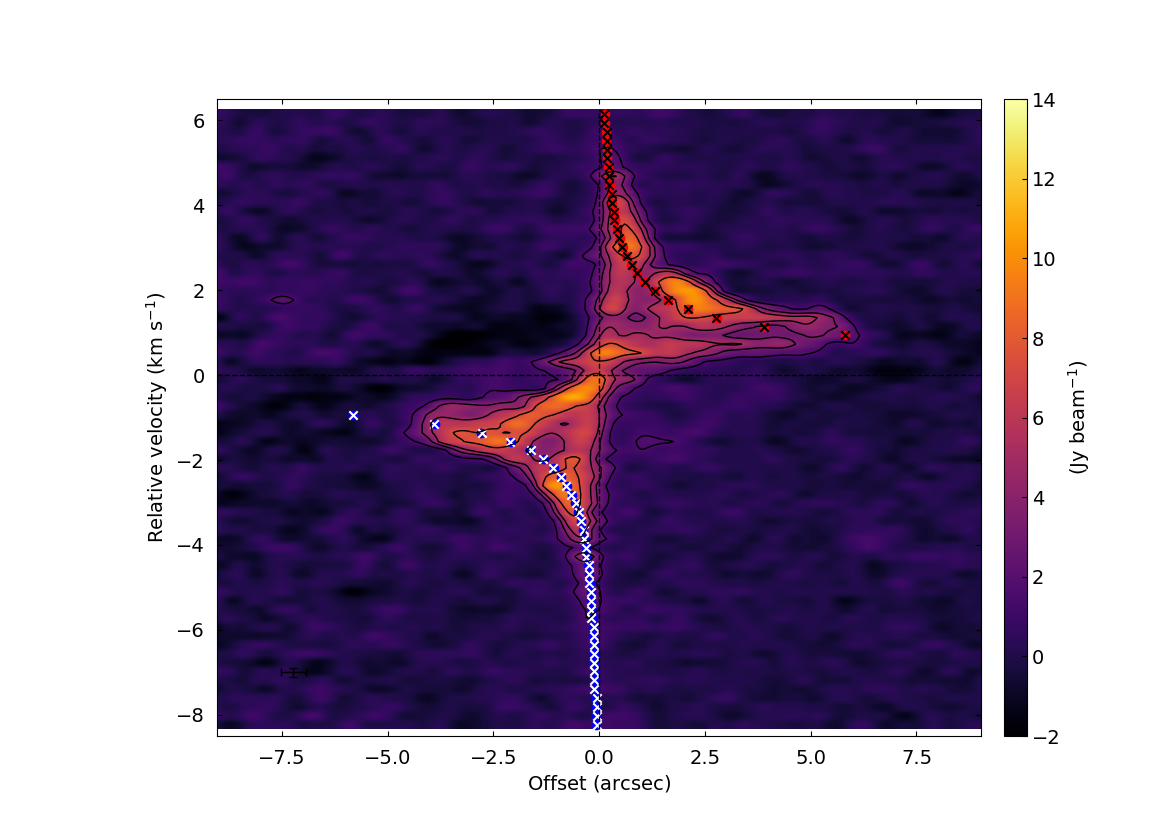

In [8]:
pv_dia6 = pv_b6.plot_pv(plot_curve=True)
pv_dia6[0].plot(r_rs_func/140.,v_rs_func,color = 'lime', alpha = 0.5)
pv_dia6[0].plot(r_bs_func/140.,v_bs_func,color = 'lime', alpha = 0.5)
pv_dia7 = pv_b7.plot_pv(plot_curve=True)

#### T estimation loop(fix v)

In [10]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

estimating for r = 3.094e-01 arcsec, v =  4.06 Kmps , Tb7 = 7.1, Tb6 = 6.2


100%|██████████| 10000/10000 [00:13<00:00, 724.85it/s]


11.5 21.5 4.0 4.8
17.7 21.5 6.4 5.9
35.4 21.5 7.8 5.1
11.5 21.7 4.5 5.4
17.7 21.7 7.5 7.0
35.4 21.7 9.7 6.4
11.5 23.5 5.3 6.8
17.7 23.5 10.9 12.7
35.4 23.5 28.0 30.2


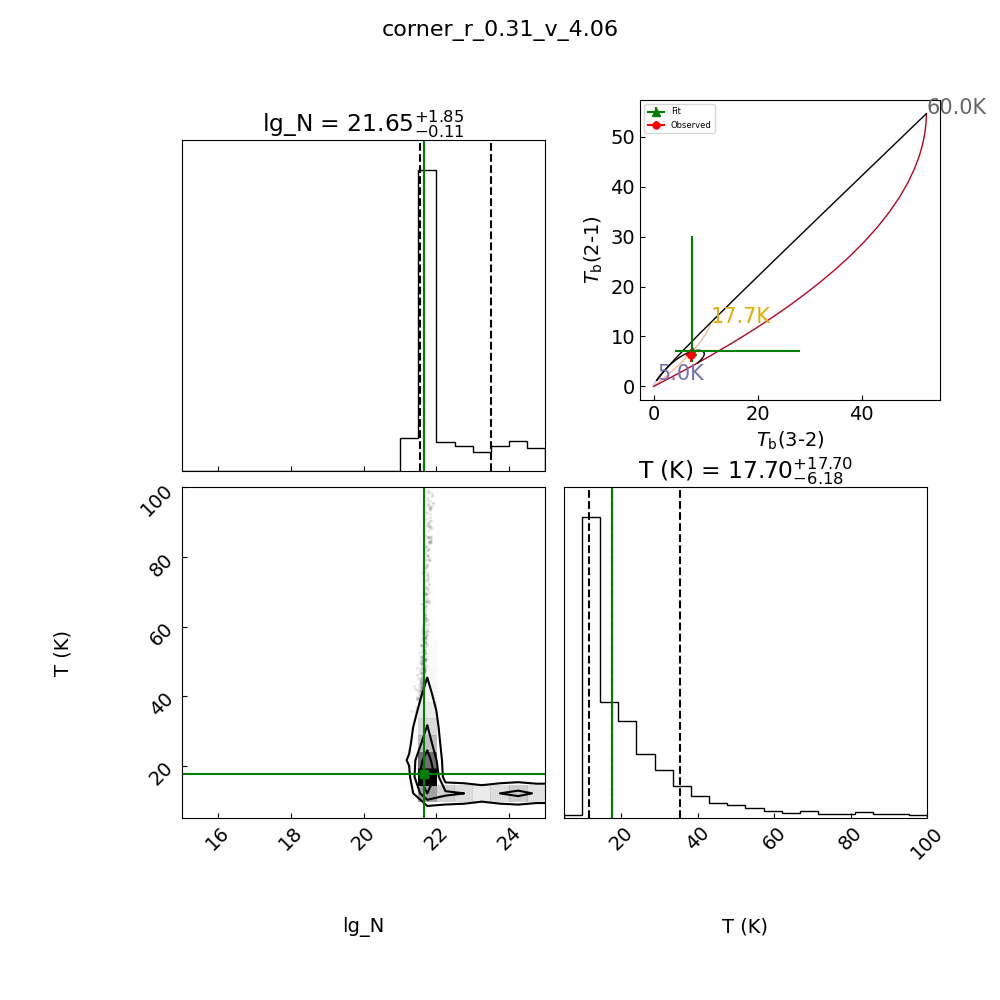

In [36]:
Texe_rs_empkep = []
Texe_upq_empkep = []
Texe_lq_empkep = []

Ncol_rs_empkep = []
Ncol_upq_empkep = []
Ncol_lq_empkep = []

plot_corner = True

np.random.seed(41)

N_conv_fraction = 1.e-7
lg_n_bounds = [15.,25.]
T_bounds = [5.,65.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0],T_bounds[-1])

op_dir_label = "redshifted_points_empkep_test"

ctr = 0

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_sur_pt_rs"][15:16], Tb_df_b6["Tb_sur_pt_rs"][15:16], 
                          pv_b6.r_as_rs[15:16], pv_b6.v_rot_redshifted[15:16]):

    print(f"estimating for r = {r:.3e} arcsec, v = {v: .2f} Kmps , Tb7 = {Tb7:.1f}, Tb6 = {Tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = Tb7, t2=Tb6, 
                                                    s1=np.sqrt((0.1*Tb7)**2 + 1.08**2), 
                                                    s2=np.sqrt((0.1*Tb6)**2 + 0.49**2), 
                                                estimator='mcmc', initial_params = [lg_n_init, T_init], 
                                                bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                                initial_scatter = 0.1, args= None,
                                                nwalkers = 20, n_steps = 10000, burn_in = 2000, thin_by = 50, return_flat= True,
                                                intensity_model = lte_model, plot_chain = True, 
                                                r_v_info = [str(round(r,3)), str(round(v,2))], 
                                                chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),"chains",op_dir_label),
                                                show_chains = False)
                
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_empkep.append(T_qtls[0])
    Texe_rs_empkep.append(T_qtls[1])
    Texe_upq_empkep.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_empkep.append(Ncol_qtls[0])
    Ncol_rs_empkep.append(Ncol_qtls[1])
    Ncol_upq_empkep.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt,ax_lt = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=Tb7, tb6=Tb6, figure = fig1,
                                axes = ax)
                            
        fig1.suptitle('corner_r_'+str(round(r,2))+'_v_'+str(round(v,2)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(r,2))+'_v_'+str(round(v,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        #plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


In [ ]:
# Calculate errorbars

T_err_empkep_rs = [np.array(Texe_rs_empkep)-np.array(Texe_lq_empkep),np.array(Texe_upq_empkep)-np.array(Texe_rs_empkep)] #[tl,tu] for tl,tu in zip(

N_err_empkep_rs = [np.array(Ncol_rs_empkep)-np.array(Ncol_lq_empkep), np.array(Ncol_upq_empkep)-np.array(Ncol_rs_empkep)]

In [ ]:
results_data = {"r_empkep_rs": pv_b6.r_as_rs,
        "Tb7_empkep_rs" : Tb_df_b7["Tb_on_point_rs"], "Tb6_empkep_rs" : Tb_df_b6["Tb_on_point_rs"],
        "Texe_rs_empkep" : Texe_rs_empkep, "Texe_err_rs_empkep" : np.array(T_err_empkep_rs).T.tolist(),
        "Ncol_rs_empkep" : Ncol_rs_empkep, "Ncol_err_rs_empkep" : np.array(N_err_empkep_rs).T.tolist()
        }

print(np.shape(T_err_empkep_rs))
print(len(pv_b6.r_as_rs), len(Tb_df_b7["Tb_on_point_rs"]), len(Tb_df_b6["Tb_on_point_rs"]), len( Ncol_rs_empkep),
      len(N_err_empkep_rs))
results_df = pd.DataFrame(data = results_data)

respath = os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv")
results_df.to_csv(path_or_buf= os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv"))

(2, 26)
26 26 26 26 2


#### Visualize results

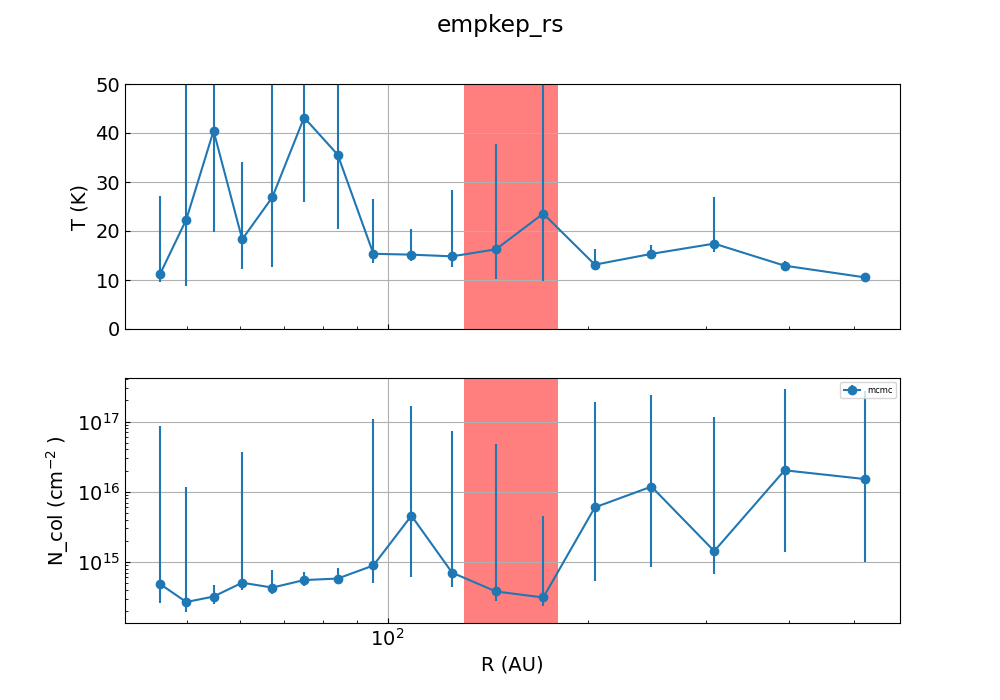

In [ ]:
vis_results_fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)

acceptable_r_range = [0.3, 5.0]

ftd_r_as_rs, ftd_Texe_rs_empkep, ftd_Terr_rs_empkep = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Texe_rs_empkep, np.array(T_err_empkep_rs).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[0].errorbar(np.array(ftd_r_as_rs)*140., ftd_Texe_rs_empkep, yerr=np.array(ftd_Terr_rs_empkep).T, marker='o', label = 'mcmc')
axes[0].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
#axes[0].set_xlim(10, 800)
axes[0].set_ylim(0,50)
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[1].legend(prop={'size': 6})

ftd_r_as_rs, ftd_Ncol_rs_empkep, ftd_N_err_rs_empkep = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Ncol_rs_empkep, np.array(N_err_empkep_rs).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[1].errorbar(np.array(ftd_r_as_rs)*140., np.array(ftd_Ncol_rs_empkep)*N_conv_fraction, 
                 yerr=np.array(ftd_N_err_rs_empkep).T*N_conv_fraction, marker='o', label = 'mcmc')

axes[1].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})
axes[1].set_xlabel("R (AU)")

vis_results_fig.suptitle("empkep_rs")

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')

### Temperature estimation (fix r)

#### Read the Data

In [10]:
# Read b7 data
pv_b7 = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    is_Tb=True, v_sys=7.33) # V_sys - 7.22, 7.27 7.384
pv_b7.read_pv(print_details = True)


# Read band 6 data
pv_b6 = pv_analyze(pv_path='uid___A002_b_6.cal.l1489_irs.spw_1_7.line.cube.clean.c_baseline_0.image.pbcor.Regridded.Smoothened.PV_69_w1.fits',
                    is_Tb=True, v_sys=7.33)
pv_b6.read_pv(print_details = True)



Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$
 rms = 1.08 K
Convert frequency to velocity
 rms = 6.92e-03 Jy beam$^-1$
 rms = 0.49 K


In [11]:
# define fix r points
# Get equidistance points

r_au_empkep_rs_fix_r = np.arange(start=42., step=42., stop=840.)
r_au_empkep_bs_fix_r = -r_au_empkep_rs_fix_r

v_100 = 2.842 #kmps # idpft-2.674 # JS- 3.2 # newft 2.842

v_rot_empkep_rs_fix_r =  emp_kep_r(r=r_au_empkep_rs_fix_r, r_b=100., v_100=v_100)
v_rot_empkep_bs_fix_r = - v_rot_empkep_rs_fix_r

plot_points = [r_au_empkep_rs_fix_r, v_rot_empkep_rs_fix_r, r_au_empkep_bs_fix_r, v_rot_empkep_bs_fix_r]

In [12]:
# Evaluate empirical keplerian curve function
r_rs_func = np.arange(start=1., step=0.5, stop=840.)   # Note that this is in AU
v_rs_func = emp_kep_r(r=r_rs_func, r_b=100., v_100=v_100)

r_bs_func = -r_rs_func
v_bs_func = -v_rs_func

In [13]:
Tb_df_b7 = pv_b7.get_tb_on_curve(curve_function = plot_points, 
                                get_surrounding_pix = False, mode='vals',
                                num_pix = 3)
Tb_df_b6 = pv_b6.get_tb_on_curve(curve_function = plot_points, 
                                    get_surrounding_pix = False, mode='vals',
                                    num_pix = 3)

#### Data Visualization

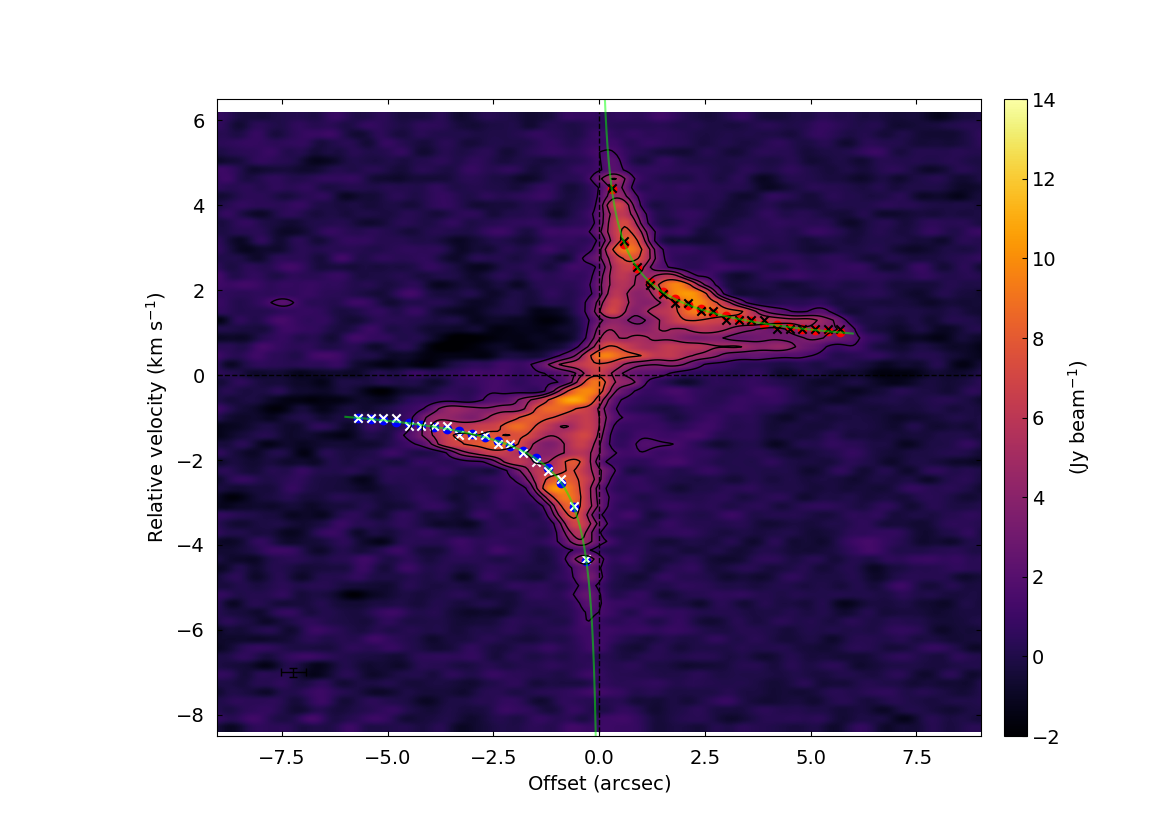

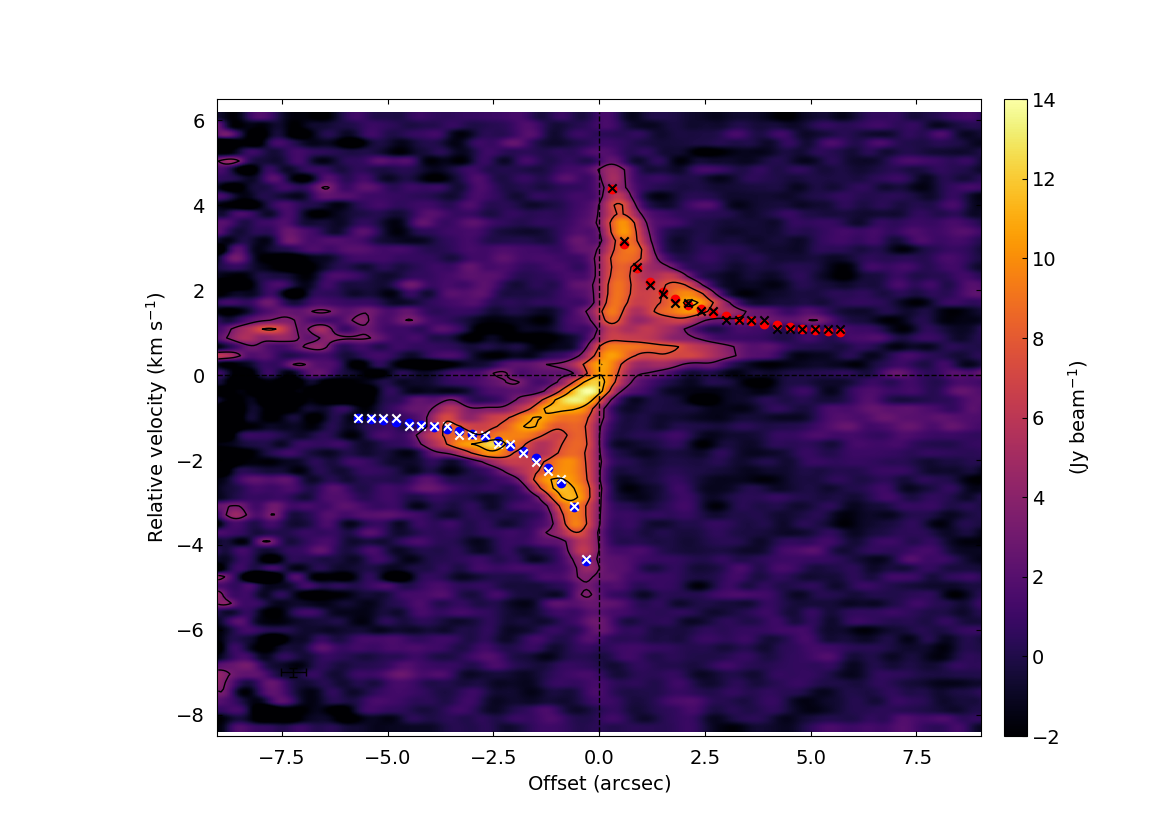

In [14]:

pv_dia6 = pv_b6.plot_pv(plot_curve=True)
pv_dia6[0].plot(r_rs_func/140.,v_rs_func,color = 'lime', alpha = 0.5)
pv_dia6[0].plot(r_bs_func/140.,v_bs_func,color = 'lime', alpha = 0.5)

pv_dia7 = pv_b7.plot_pv(plot_curve=True)

#### T estimation loop (fix r)

In [15]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

estimating for r = 3.000e-01 arcsec, v =  4.39 Kmps , Tb7 = 4.3, Tb6 = 3.6


100%|██████████| 9000/9000 [00:55<00:00, 160.91it/s]


dtauv_dT =  4.959014936112649e-06
dtauv_dT =  1.8071835118511525e-06
Tb7_dIv_dN = 2.18e-14, Tb6_dIv_dN = 1.70e-14
Tb7_dIv_dT = 0.19, Tb6_dIv_dT = 0.13
Ncols and lgNcols up 2.42e+14, lgNc = 1.44e+01
Ncols and lgNcols med 1.99e+14, lgNc = 1.43e+01
Ncols and lgNcols dwn 1.69e+14, lgNc = 1.42e+01
del T -> + 18.75, - 13.15
del N -> + 4.31e+13, - 2.96e+13
[[2.61459096 3.7319049 ]]
[[1.84129155 2.62900096]]


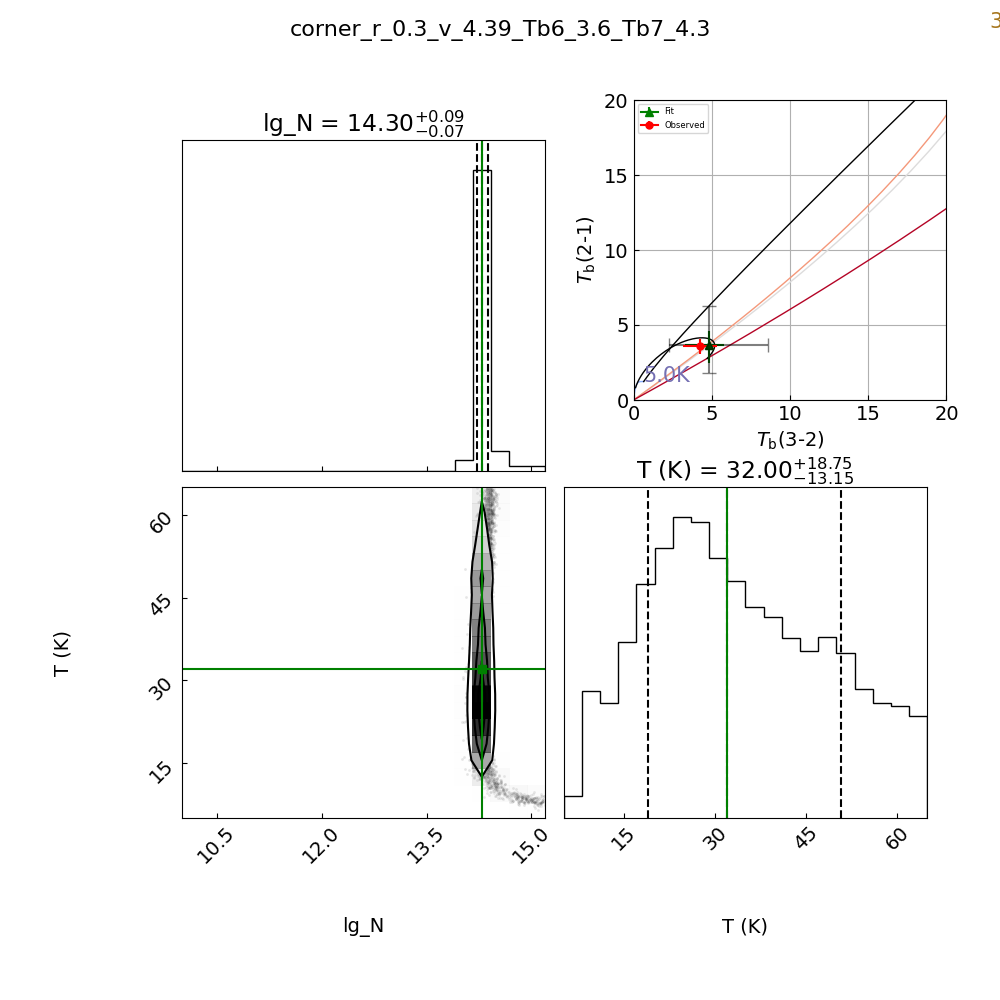

estimating for r = 6.000e-01 arcsec, v =  3.10 Kmps , Tb7 = 9.0, Tb6 = 8.0


100%|██████████| 9000/9000 [00:56<00:00, 159.06it/s]


dtauv_dT =  3.10389012157916e-05
dtauv_dT =  1.2588917898211778e-05
Tb7_dIv_dN = 1.36e-14, Tb6_dIv_dN = 1.31e-14
Tb7_dIv_dT = 0.47, Tb6_dIv_dT = 0.38
Ncols and lgNcols up 5.35e+14, lgNc = 1.47e+01
Ncols and lgNcols med 4.81e+14, lgNc = 1.47e+01
Ncols and lgNcols dwn 4.43e+14, lgNc = 1.46e+01
del T -> + 7.92, - 5.87
del N -> + 5.45e+13, - 3.74e+13
[[2.81975306 3.81216416]]
[[2.28083352 3.08717071]]


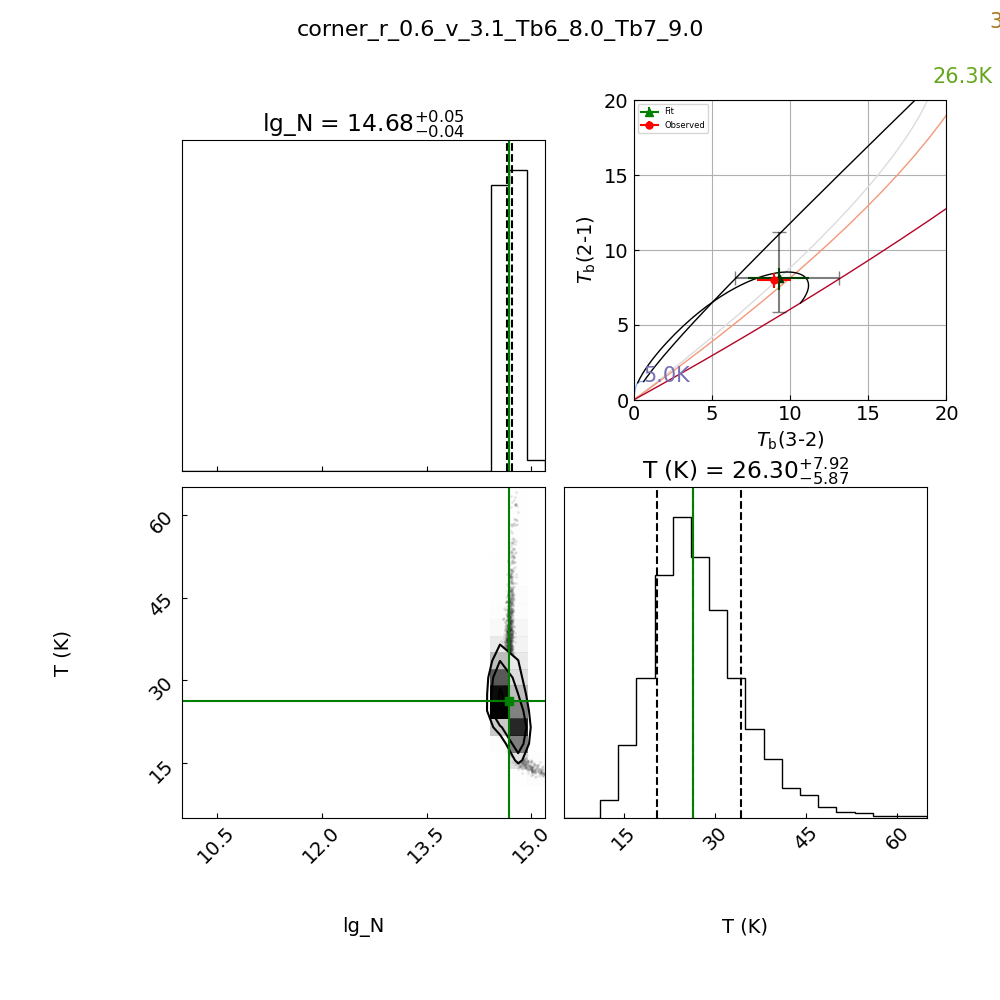

estimating for r = 9.000e-01 arcsec, v =  2.53 Kmps , Tb7 = 6.6, Tb6 = 6.1


100%|██████████| 9000/9000 [00:54<00:00, 164.46it/s]


dtauv_dT =  3.642682977528853e-05
dtauv_dT =  1.576266712722807e-05
Tb7_dIv_dN = 1.50e-14, Tb6_dIv_dN = 1.46e-14
Tb7_dIv_dT = 0.40, Tb6_dIv_dT = 0.33
Ncols and lgNcols up 4.18e+14, lgNc = 1.46e+01
Ncols and lgNcols med 3.50e+14, lgNc = 1.45e+01
Ncols and lgNcols dwn 3.14e+14, lgNc = 1.45e+01
del T -> + 10.37, - 7.44
del N -> + 6.81e+13, - 3.58e+13
[[3.04520403 4.29744994]]
[[2.53923357 3.60027677]]


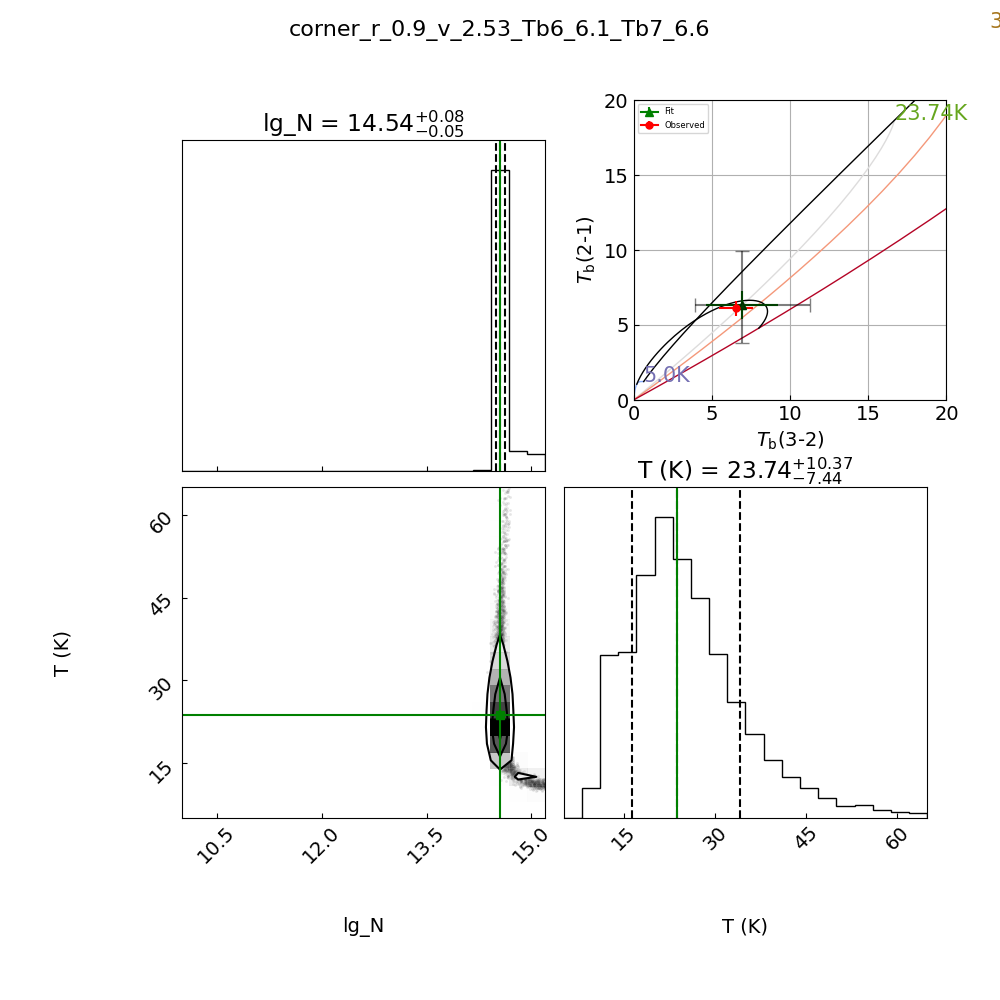

estimating for r = 1.200e+00 arcsec, v =  2.19 Kmps , Tb7 = 6.3, Tb6 = 5.4


100%|██████████| 9000/9000 [00:57<00:00, 157.31it/s]


dtauv_dT =  1.2338087066352945e-05
dtauv_dT =  4.7225151405030075e-06
Tb7_dIv_dN = 1.84e-14, Tb6_dIv_dN = 1.57e-14
Tb7_dIv_dT = 0.31, Tb6_dIv_dT = 0.23
Ncols and lgNcols up 3.53e+14, lgNc = 1.45e+01
Ncols and lgNcols med 3.11e+14, lgNc = 1.45e+01
Ncols and lgNcols dwn 2.78e+14, lgNc = 1.44e+01
del T -> + 14.28, - 9.07
del N -> + 4.27e+13, - 3.31e+13
[[2.88635705 4.5116479 ]]
[[2.16263845 3.37289472]]


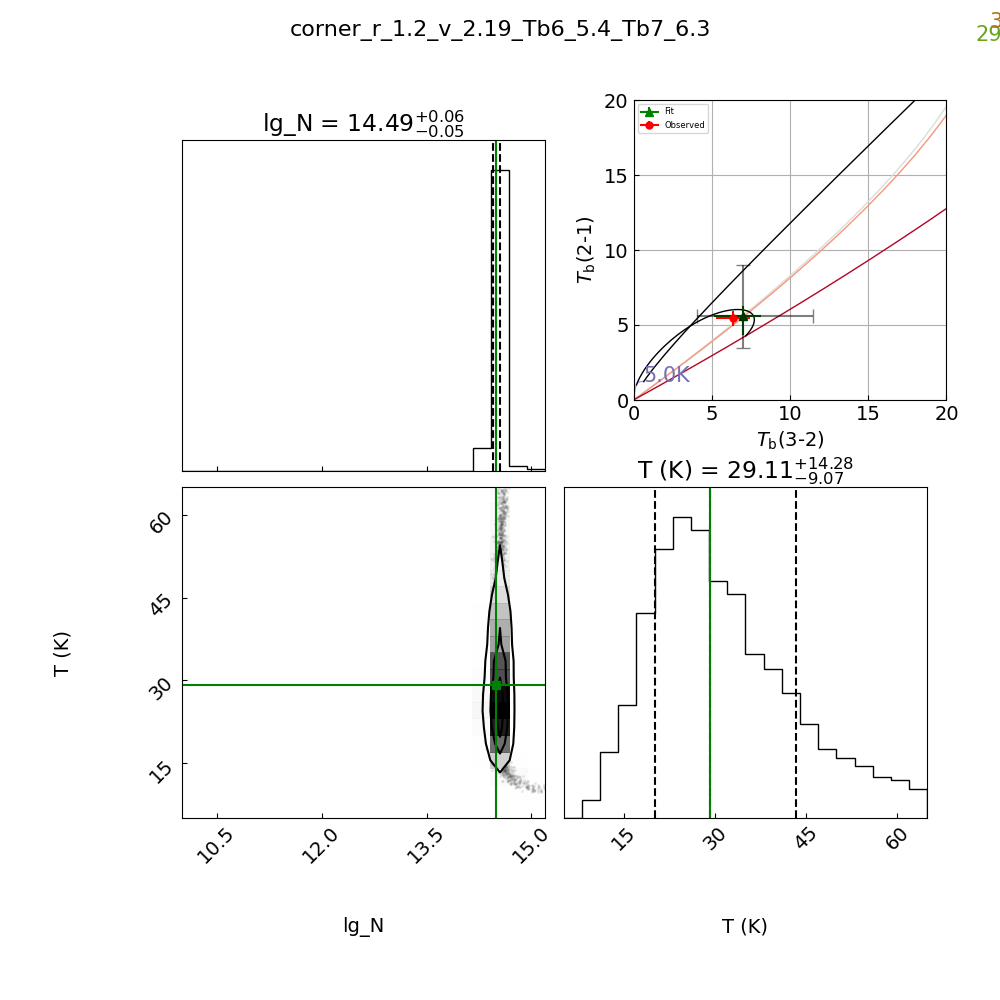

estimating for r = 1.500e+00 arcsec, v =  1.96 Kmps , Tb7 = 7.6, Tb6 = 7.3


100%|██████████| 9000/9000 [00:56<00:00, 160.33it/s]


dtauv_dT =  6.276286289484701e-05
dtauv_dT =  2.8506273072913095e-05
Tb7_dIv_dN = 1.21e-14, Tb6_dIv_dN = 1.26e-14
Tb7_dIv_dT = 0.49, Tb6_dIv_dT = 0.43
Ncols and lgNcols up 5.60e+14, lgNc = 1.47e+01
Ncols and lgNcols med 4.39e+14, lgNc = 1.46e+01
Ncols and lgNcols dwn 3.94e+14, lgNc = 1.46e+01
del T -> + 7.49, - 6.14
del N -> + 1.21e+14, - 4.41e+13
[[3.08266464 3.98551357]]
[[2.70233883 3.57118319]]


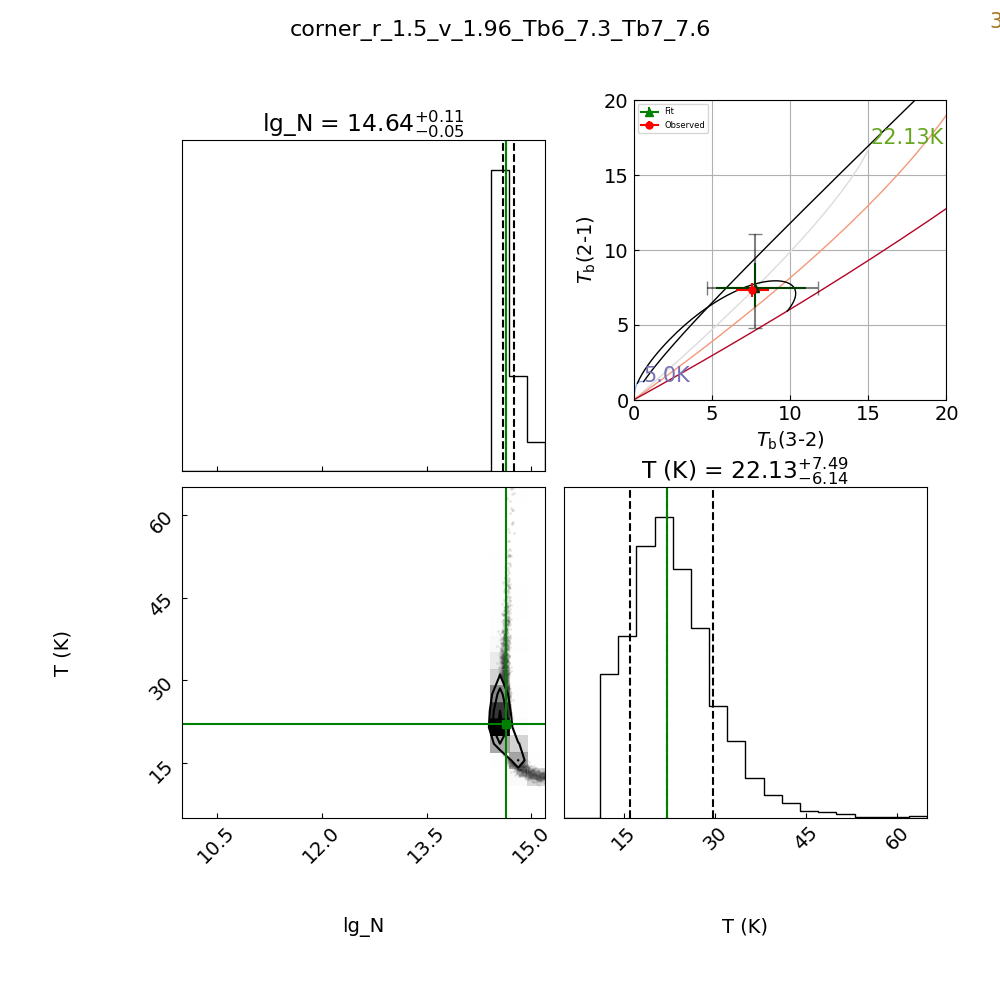

estimating for r = 1.800e+00 arcsec, v =  1.79 Kmps , Tb7 = 9.6, Tb6 = 7.3


100%|██████████| 9000/9000 [00:55<00:00, 163.57it/s]


dtauv_dT =  5.340491076157489e-06
dtauv_dT =  1.8174318189081546e-06
Tb7_dIv_dN = 1.79e-14, Tb6_dIv_dN = 1.41e-14
Tb7_dIv_dT = 0.33, Tb6_dIv_dT = 0.23
Ncols and lgNcols up 5.01e+14, lgNc = 1.47e+01
Ncols and lgNcols med 4.53e+14, lgNc = 1.47e+01
Ncols and lgNcols dwn 4.15e+14, lgNc = 1.46e+01
del T -> + 12.40, - 8.84
del N -> + 4.76e+13, - 3.86e+13
[[3.01385731 4.20142251]]
[[2.07836057 2.89200714]]


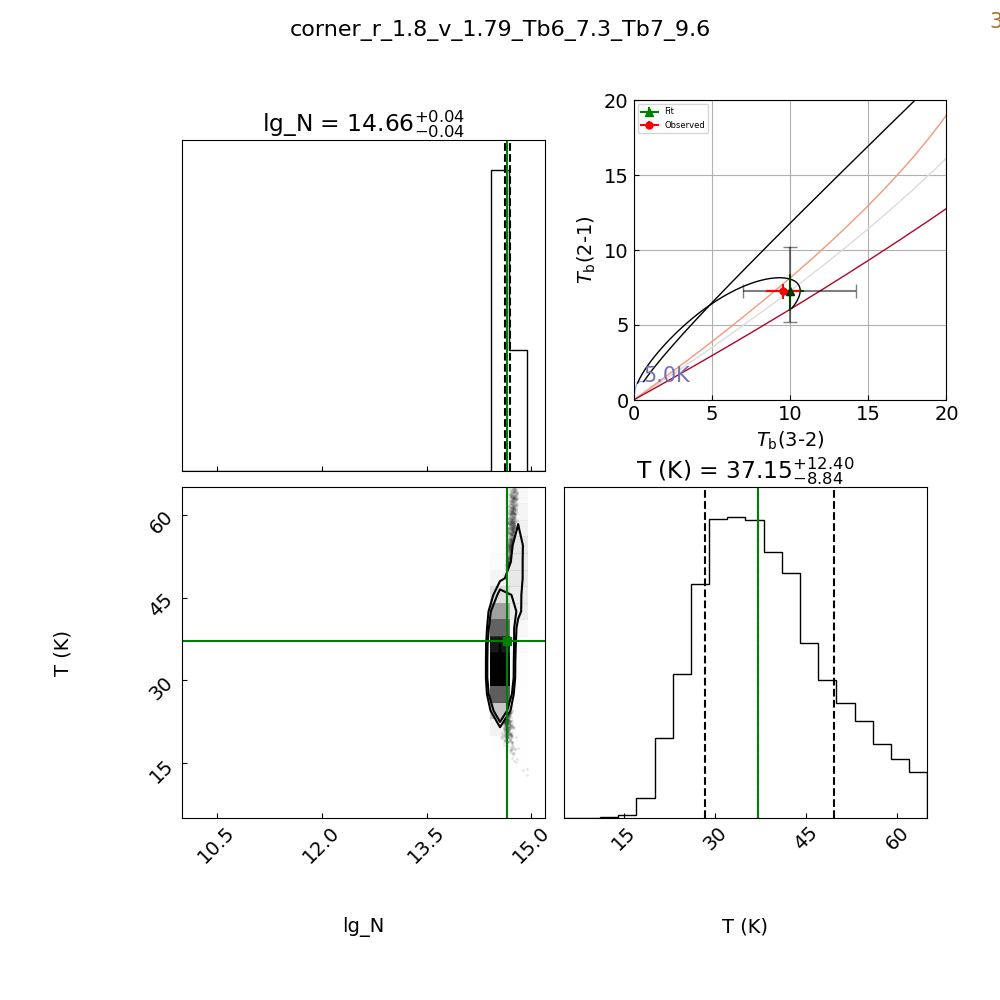

estimating for r = 2.100e+00 arcsec, v =  1.66 Kmps , Tb7 = 11.2, Tb6 = 9.8


100%|██████████| 9000/9000 [00:57<00:00, 156.58it/s]


dtauv_dT =  3.199700225255888e-05
dtauv_dT =  1.2617364638091558e-05
Tb7_dIv_dN = 1.18e-14, Tb6_dIv_dN = 1.17e-14
Tb7_dIv_dT = 0.54, Tb6_dIv_dT = 0.44
Ncols and lgNcols up 6.84e+14, lgNc = 1.48e+01
Ncols and lgNcols med 6.23e+14, lgNc = 1.48e+01
Ncols and lgNcols dwn 5.81e+14, lgNc = 1.48e+01
del T -> + 6.26, - 5.24
del N -> + 6.15e+13, - 4.21e+13
[[2.89225654 3.4831843 ]]
[[2.33661206 2.82420756]]


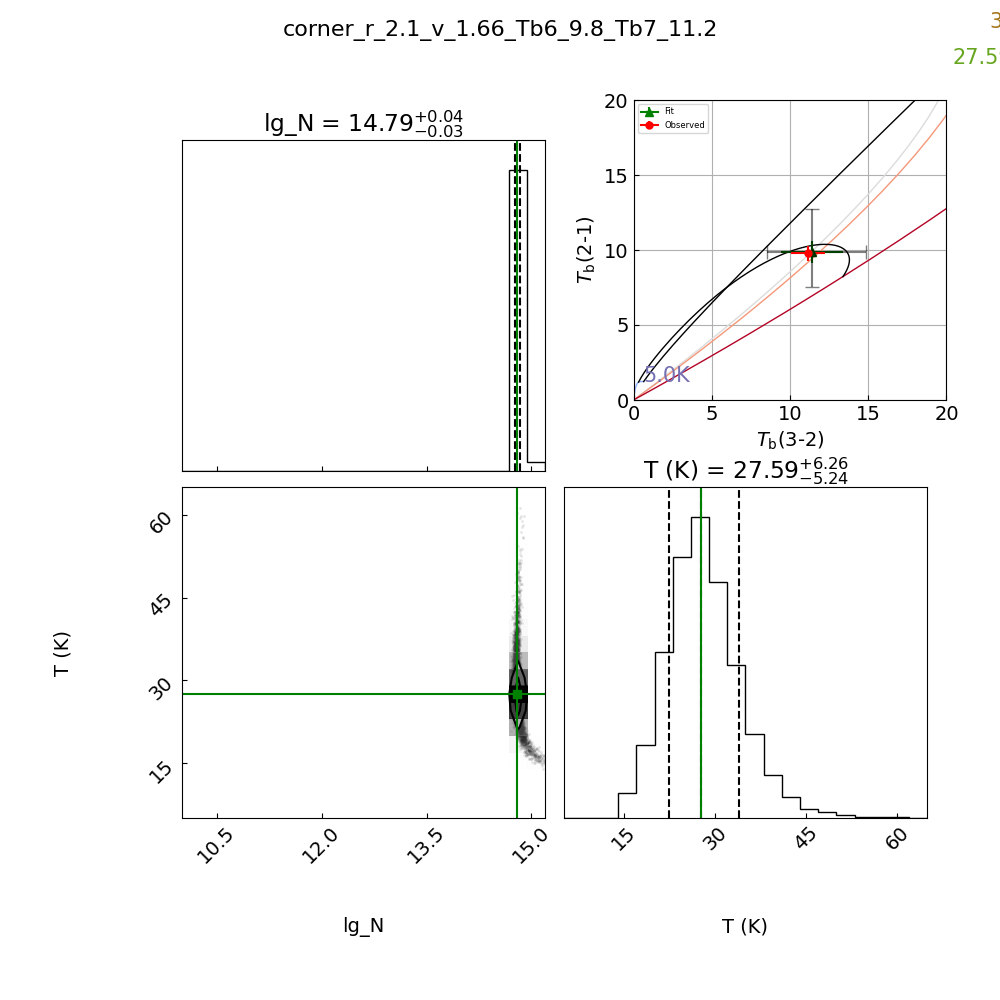

estimating for r = 2.400e+00 arcsec, v =  1.55 Kmps , Tb7 = 9.0, Tb6 = 9.5


100%|██████████| 9000/9000 [00:55<00:00, 162.54it/s]


dtauv_dT =  0.00019287956823832184
dtauv_dT =  9.852971597282208e-05
Tb7_dIv_dN = 6.20e-15, Tb6_dIv_dN = 7.37e-15
Tb7_dIv_dT = 0.69, Tb6_dIv_dT = 0.66
Ncols and lgNcols up 1.06e+15, lgNc = 1.50e+01
Ncols and lgNcols med 6.93e+14, lgNc = 1.48e+01
Ncols and lgNcols dwn 5.76e+14, lgNc = 1.48e+01
del T -> + 4.71, - 3.28
del N -> + 3.67e+14, - 1.17e+14
[[2.37157399 3.95774204]]
[[2.34090743 4.12822226]]


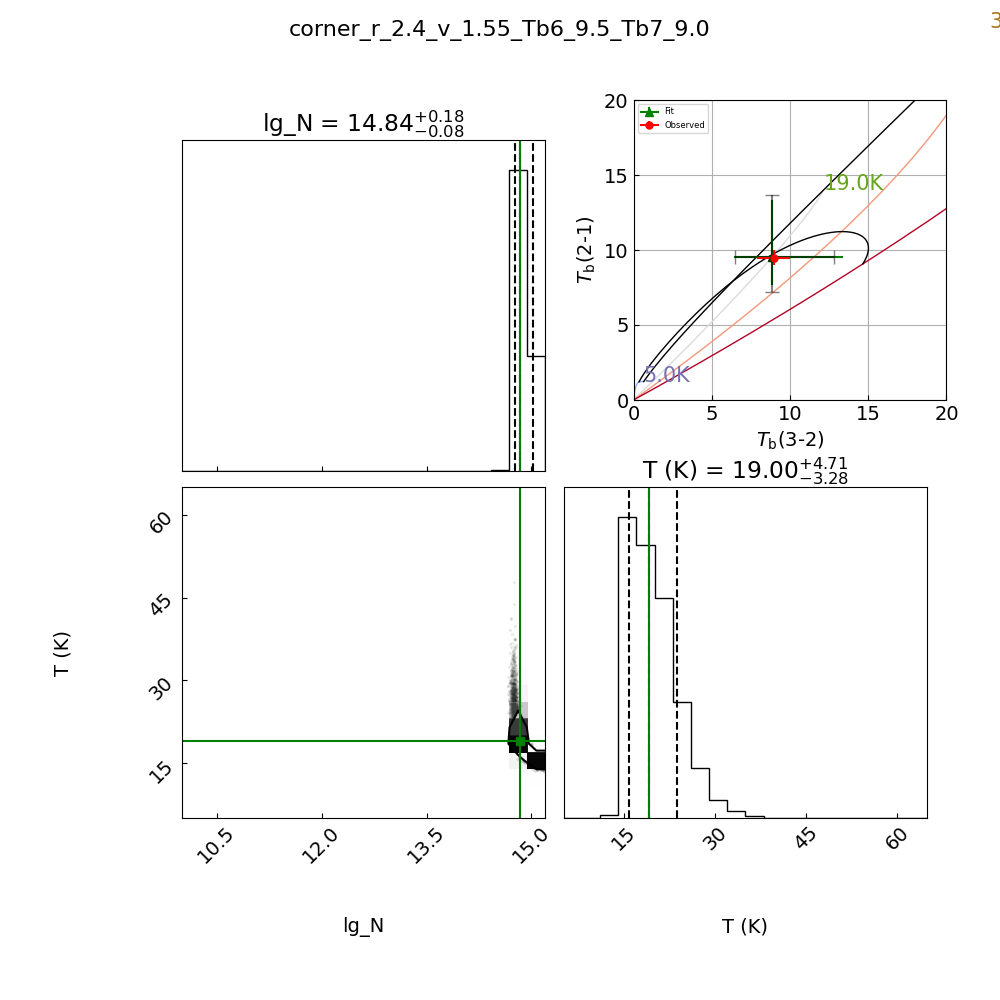

estimating for r = 2.700e+00 arcsec, v =  1.46 Kmps , Tb7 = 6.4, Tb6 = 8.8


100%|██████████| 9000/9000 [00:53<00:00, 168.23it/s]


dtauv_dT =  0.0006217987390502336
dtauv_dT =  0.00039660686728101727
Tb7_dIv_dN = 2.80e-15, Tb6_dIv_dN = 3.24e-15
Tb7_dIv_dT = 0.77, Tb6_dIv_dT = 0.82
Ncols and lgNcols up 1.28e+15, lgNc = 1.51e+01
Ncols and lgNcols med 8.64e+14, lgNc = 1.49e+01
Ncols and lgNcols dwn 6.05e+14, lgNc = 1.48e+01
del T -> + 2.76, - 1.21
del N -> + 4.16e+14, - 2.58e+14
[[1.18148864 2.43279196]]
[[1.30095628 2.64643544]]


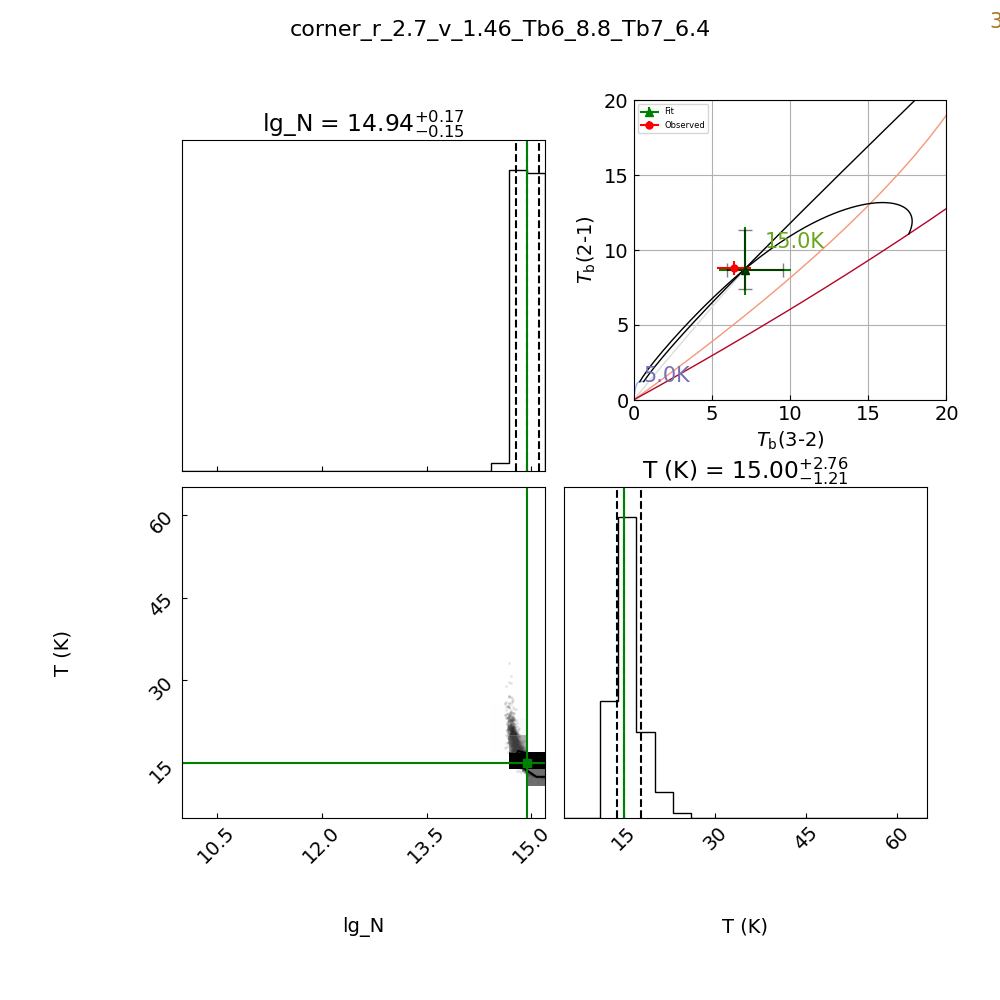

estimating for r = 3.000e+00 arcsec, v =  1.39 Kmps , Tb7 = 2.7, Tb6 = 6.6


100%|██████████| 9000/9000 [00:54<00:00, 166.26it/s]


dtauv_dT =  0.0010536519713060205
dtauv_dT =  0.0008747981125748549
Tb7_dIv_dN = 2.82e-15, Tb6_dIv_dN = 2.96e-15
Tb7_dIv_dT = 0.68, Tb6_dIv_dT = 0.81
Ncols and lgNcols up 1.11e+15, lgNc = 1.50e+01
Ncols and lgNcols med 6.70e+14, lgNc = 1.48e+01
Ncols and lgNcols dwn 4.45e+14, lgNc = 1.46e+01
del T -> + 2.10, - 1.02
del N -> + 4.41e+14, - 2.25e+14
[[0.94418402 1.89763407]]
[[1.06289149 2.14169059]]


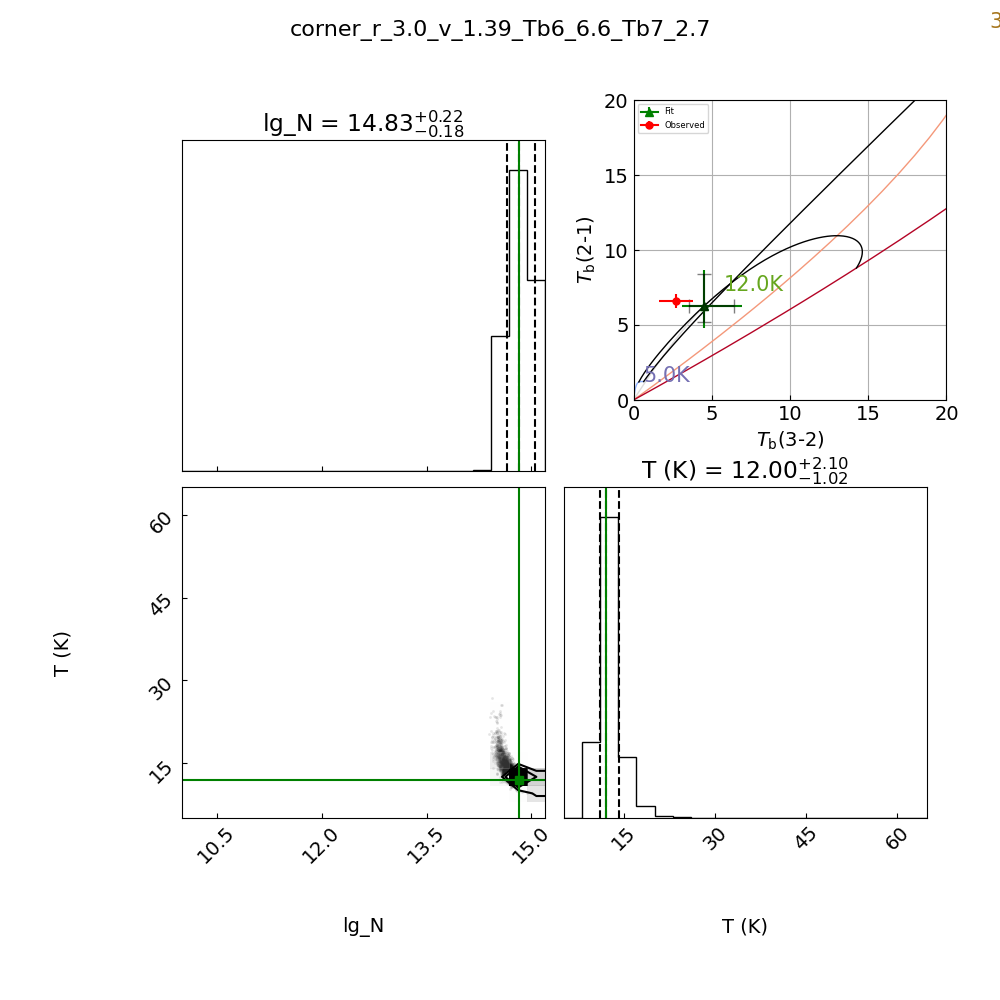

estimating for r = 3.300e+00 arcsec, v =  1.32 Kmps , Tb7 = 2.9, Tb6 = 6.5


100%|██████████| 9000/9000 [00:53<00:00, 166.85it/s]


dtauv_dT =  0.0010553570500507882
dtauv_dT =  0.0008778176386240826
Tb7_dIv_dN = 2.82e-15, Tb6_dIv_dN = 2.96e-15
Tb7_dIv_dT = 0.68, Tb6_dIv_dT = 0.81
Ncols and lgNcols up 1.13e+15, lgNc = 1.51e+01
Ncols and lgNcols med 6.68e+14, lgNc = 1.48e+01
Ncols and lgNcols dwn 4.31e+14, lgNc = 1.46e+01
del T -> + 2.25, - 1.02
del N -> + 4.59e+14, - 2.37e+14
[[0.96737396 2.00966516]]
[[1.0861487  2.27301229]]


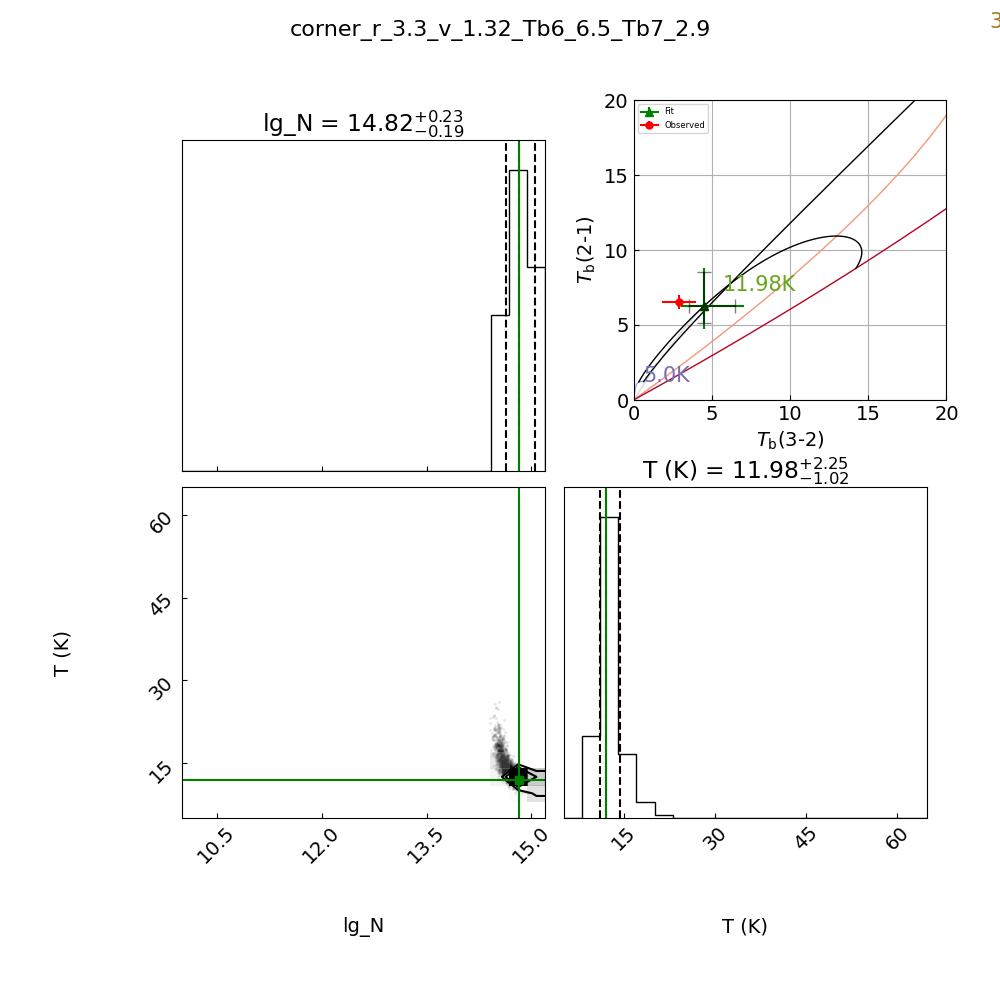

estimating for r = 3.600e+00 arcsec, v =  1.27 Kmps , Tb7 = 2.9, Tb6 = 6.6


100%|██████████| 9000/9000 [00:53<00:00, 166.92it/s]


dtauv_dT =  0.001088109296348925
dtauv_dT =  0.0009057520489383201
Tb7_dIv_dN = 2.70e-15, Tb6_dIv_dN = 2.79e-15
Tb7_dIv_dT = 0.69, Tb6_dIv_dT = 0.82
Ncols and lgNcols up 1.13e+15, lgNc = 1.51e+01
Ncols and lgNcols med 6.87e+14, lgNc = 1.48e+01
Ncols and lgNcols dwn 4.42e+14, lgNc = 1.46e+01
del T -> + 2.09, - 1.02
del N -> + 4.40e+14, - 2.45e+14
[[0.96720308 1.86734456]]
[[1.07982751 2.10159776]]


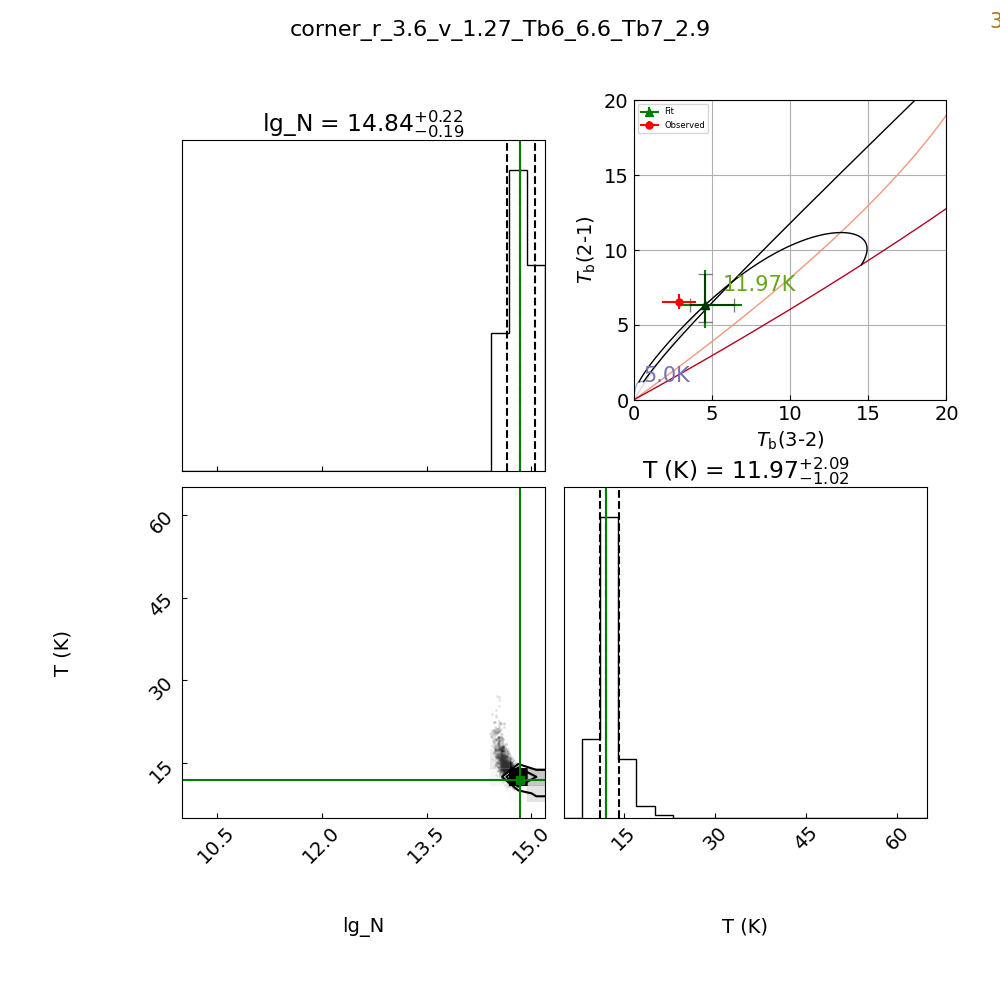

estimating for r = 3.900e+00 arcsec, v =  1.22 Kmps , Tb7 = 3.0, Tb6 = 6.3


100%|██████████| 9000/9000 [00:53<00:00, 167.14it/s]


dtauv_dT =  0.0010270698007600588
dtauv_dT =  0.0008649036504126936
Tb7_dIv_dN = 3.02e-15, Tb6_dIv_dN = 3.23e-15
Tb7_dIv_dT = 0.67, Tb6_dIv_dT = 0.80
Ncols and lgNcols up 1.10e+15, lgNc = 1.50e+01
Ncols and lgNcols med 6.31e+14, lgNc = 1.48e+01
Ncols and lgNcols dwn 4.06e+14, lgNc = 1.46e+01
del T -> + 2.59, - 1.07
del N -> + 4.64e+14, - 2.25e+14
[[0.98338407 2.22177668]]
[[1.11884122 2.55094643]]


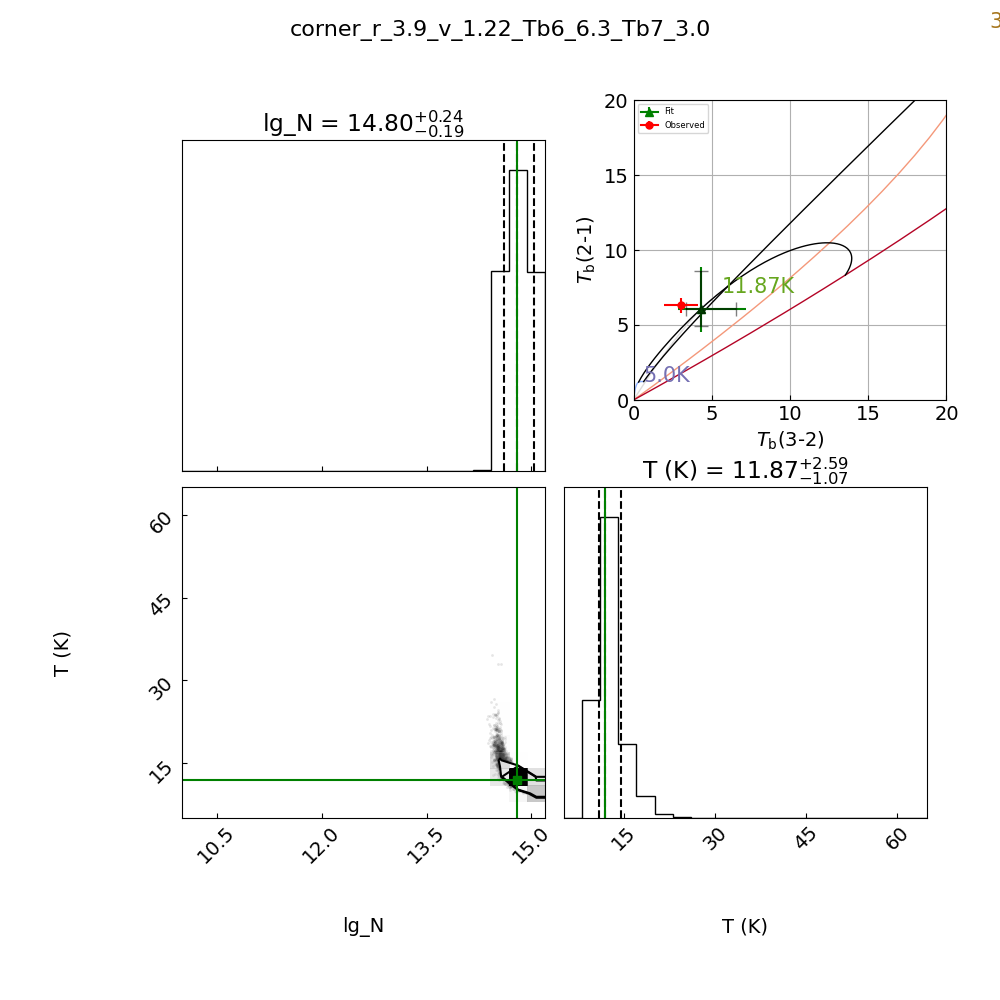

estimating for r = 4.200e+00 arcsec, v =  1.17 Kmps , Tb7 = 0.4, Tb6 = 3.0


100%|██████████| 9000/9000 [00:51<00:00, 174.09it/s]


dtauv_dT =  0.000735277478244107
dtauv_dT =  0.0008904461391615169
Tb7_dIv_dN = 4.68e-15, Tb6_dIv_dN = 7.63e-15
Tb7_dIv_dT = 0.32, Tb6_dIv_dT = 0.53
Ncols and lgNcols up 6.52e+14, lgNc = 1.48e+01
Ncols and lgNcols med 2.29e+14, lgNc = 1.44e+01
Ncols and lgNcols dwn 1.28e+14, lgNc = 1.41e+01
del T -> + 6.18, - 2.10
del N -> + 4.22e+14, - 1.02e+14
[[0.82166903 2.78830253]]
[[1.353073   4.57991058]]


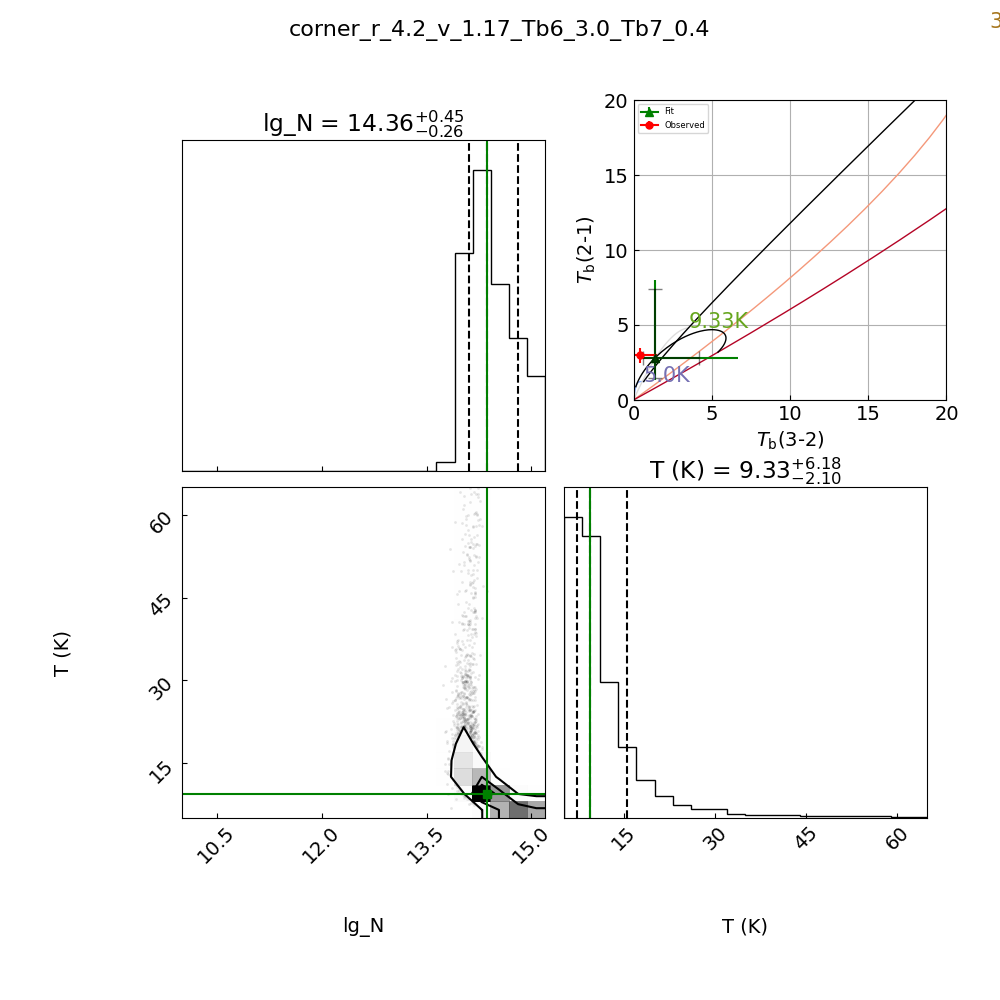

estimating for r = 4.500e+00 arcsec, v =  1.13 Kmps , Tb7 = 0.2, Tb6 = 3.7


100%|██████████| 9000/9000 [00:54<00:00, 166.30it/s]


dtauv_dT =  0.0011974441738507077
dtauv_dT =  0.0015173658575130004
Tb7_dIv_dN = 3.37e-15, Tb6_dIv_dN = 4.55e-15
Tb7_dIv_dT = 0.42, Tb6_dIv_dT = 0.67
Ncols and lgNcols up 7.94e+14, lgNc = 1.49e+01
Ncols and lgNcols med 3.51e+14, lgNc = 1.45e+01
Ncols and lgNcols dwn 1.92e+14, lgNc = 1.43e+01
del T -> + 3.46, - 1.33
del N -> + 4.42e+14, - 1.59e+14
[[0.77582085 2.08834422]]
[[1.14585757 3.06807869]]


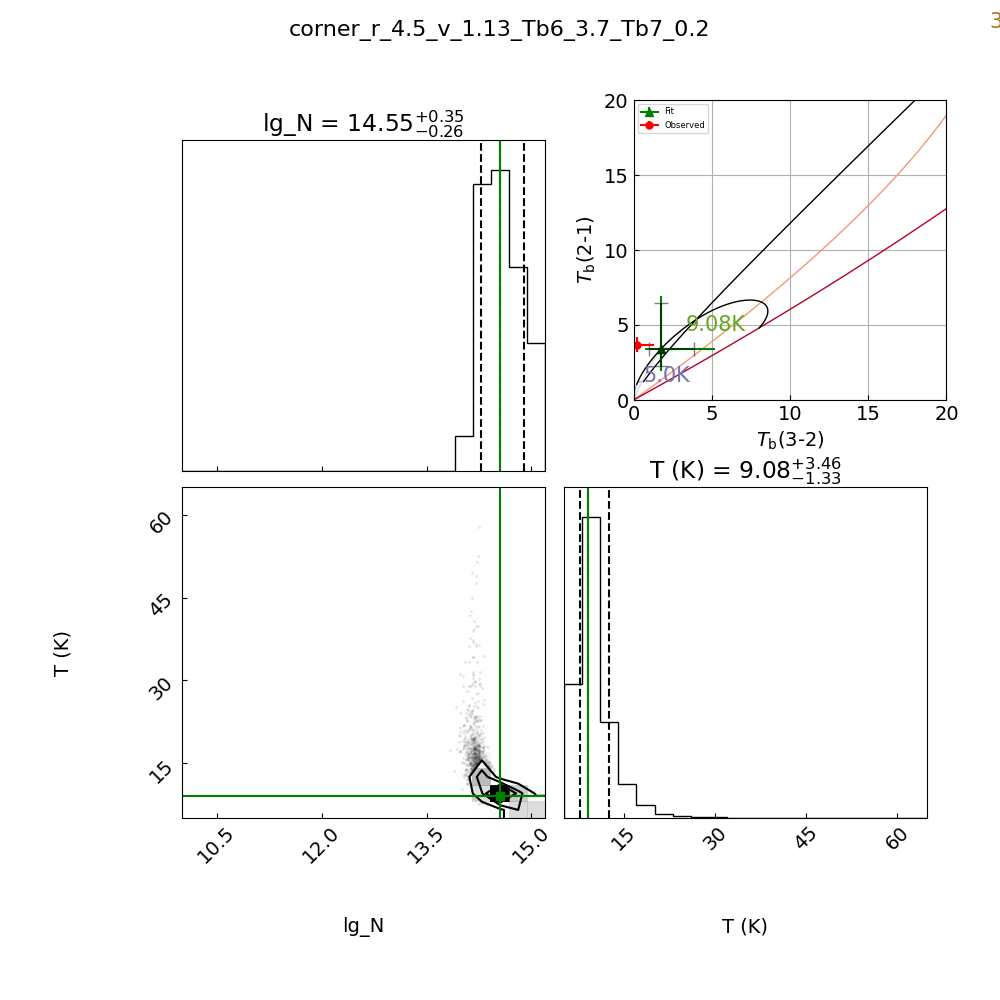

estimating for r = 4.800e+00 arcsec, v =  1.10 Kmps , Tb7 = 1.0, Tb6 = 4.5


100%|██████████| 9000/9000 [00:54<00:00, 166.55it/s]


dtauv_dT =  0.0011849862233475896
dtauv_dT =  0.0012906586039907705
Tb7_dIv_dN = 3.39e-15, Tb6_dIv_dN = 4.04e-15
Tb7_dIv_dT = 0.51, Tb6_dIv_dT = 0.72
Ncols and lgNcols up 8.95e+14, lgNc = 1.50e+01
Ncols and lgNcols med 4.35e+14, lgNc = 1.46e+01
Ncols and lgNcols dwn 2.56e+14, lgNc = 1.44e+01
del T -> + 2.94, - 1.22
del N -> + 4.60e+14, - 1.79e+14
[[0.87214407 2.17005321]]
[[1.14060667 2.82269044]]


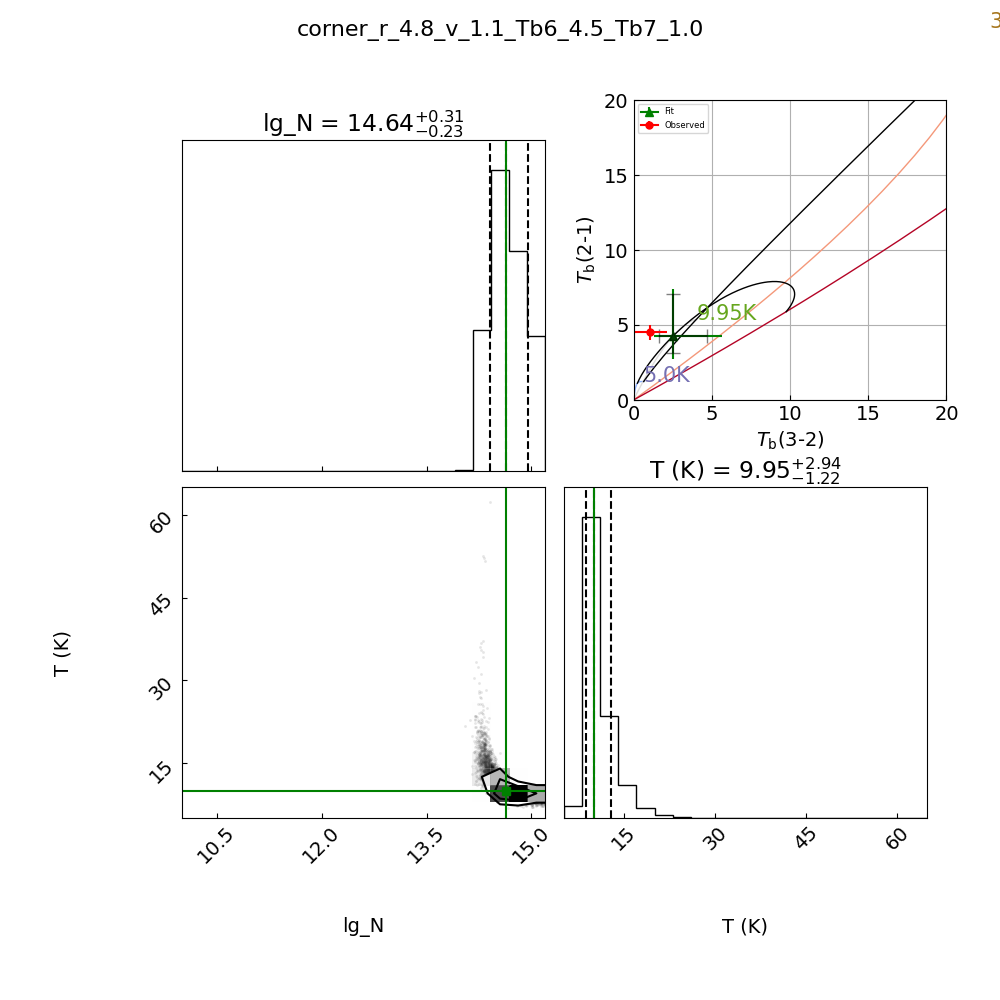

estimating for r = 5.100e+00 arcsec, v =  1.06 Kmps , Tb7 = 1.2, Tb6 = 4.3


100%|██████████| 9000/9000 [00:53<00:00, 167.60it/s]


dtauv_dT =  0.0011467595055103838
dtauv_dT =  0.001265704040539116
Tb7_dIv_dN = 3.51e-15, Tb6_dIv_dN = 4.31e-15
Tb7_dIv_dT = 0.49, Tb6_dIv_dT = 0.71
Ncols and lgNcols up 8.60e+14, lgNc = 1.49e+01
Ncols and lgNcols med 4.12e+14, lgNc = 1.46e+01
Ncols and lgNcols dwn 2.36e+14, lgNc = 1.44e+01
del T -> + 3.37, - 1.31
del N -> + 4.48e+14, - 1.76e+14
[[0.89458611 2.29090447]]
[[1.19611095 3.06638507]]


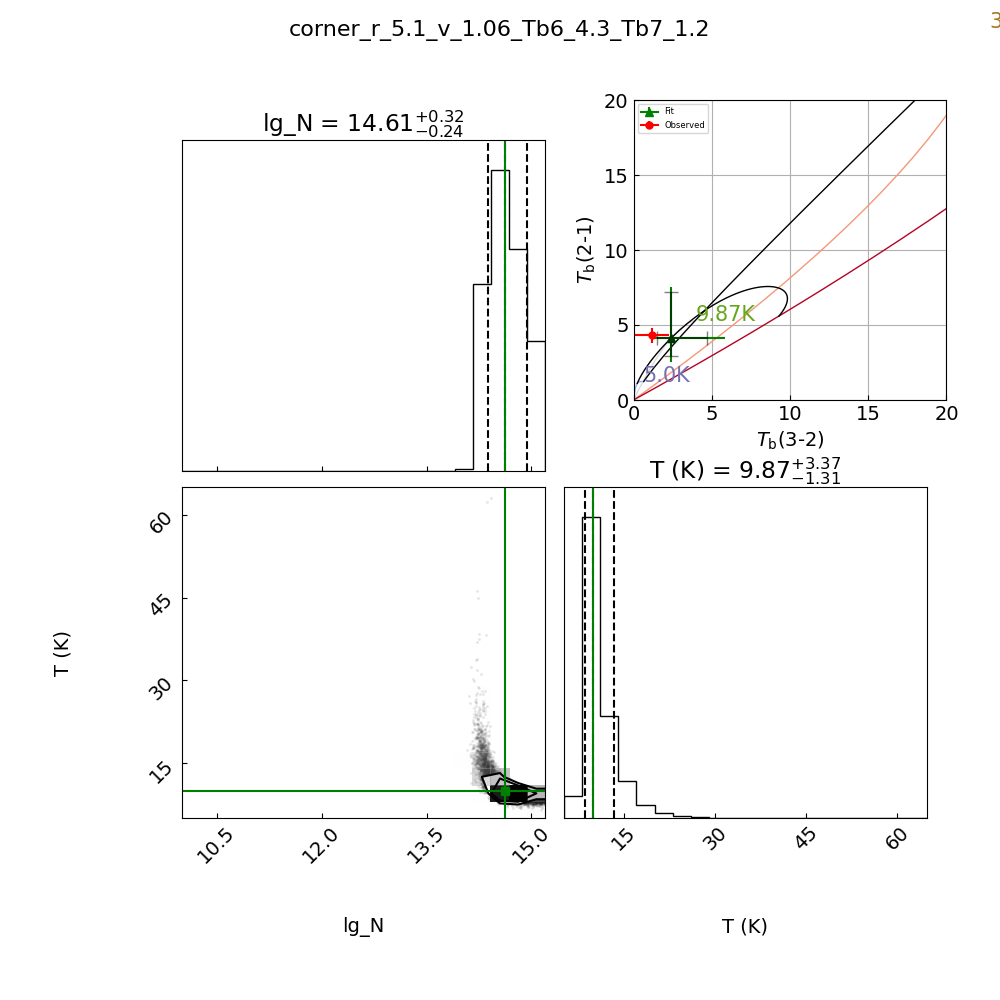

estimating for r = 5.400e+00 arcsec, v =  1.03 Kmps , Tb7 = 0.5, Tb6 = 3.7


100%|██████████| 9000/9000 [00:53<00:00, 169.76it/s]


dtauv_dT =  0.0011486505479157026
dtauv_dT =  0.001434949599491314
Tb7_dIv_dN = 3.49e-15, Tb6_dIv_dN = 4.77e-15
Tb7_dIv_dT = 0.42, Tb6_dIv_dT = 0.66
Ncols and lgNcols up 7.97e+14, lgNc = 1.49e+01
Ncols and lgNcols med 3.43e+14, lgNc = 1.45e+01
Ncols and lgNcols dwn 1.90e+14, lgNc = 1.43e+01
del T -> + 3.67, - 1.36
del N -> + 4.54e+14, - 1.53e+14
[[0.78046885 2.20831271]]
[[1.15659438 3.25156144]]


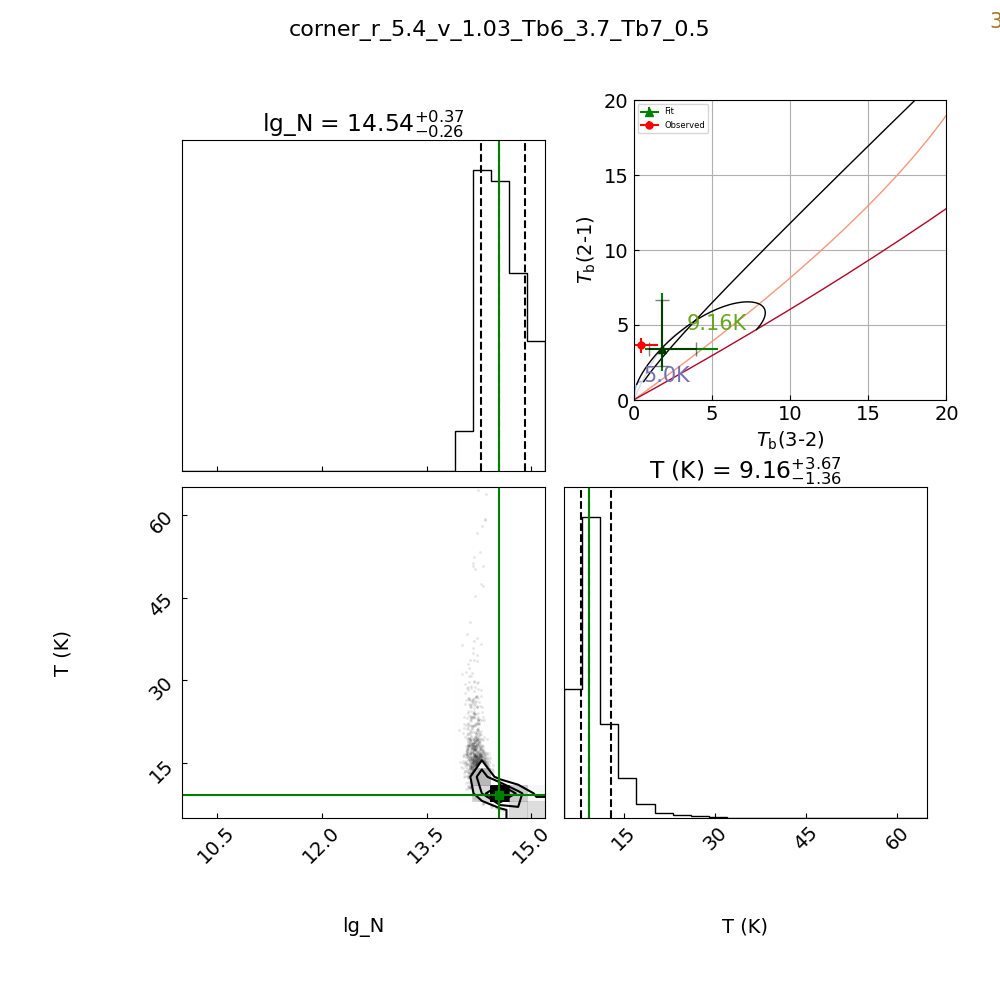

estimating for r = 5.700e+00 arcsec, v =  1.01 Kmps , Tb7 = 1.2, Tb6 = 3.3


100%|██████████| 9000/9000 [00:51<00:00, 173.40it/s]


dtauv_dT =  0.0005429106033779694
dtauv_dT =  0.0005483043296562347
Tb7_dIv_dN = 6.02e-15, Tb6_dIv_dN = 9.15e-15
Tb7_dIv_dT = 0.34, Tb6_dIv_dT = 0.50
Ncols and lgNcols up 6.74e+14, lgNc = 1.48e+01
Ncols and lgNcols med 2.28e+14, lgNc = 1.44e+01
Ncols and lgNcols dwn 1.42e+14, lgNc = 1.42e+01
del T -> + 7.40, - 2.78
del N -> + 4.46e+14, - 8.53e+13
[[1.0726508  3.67449743]]
[[1.59104354 5.5046654 ]]


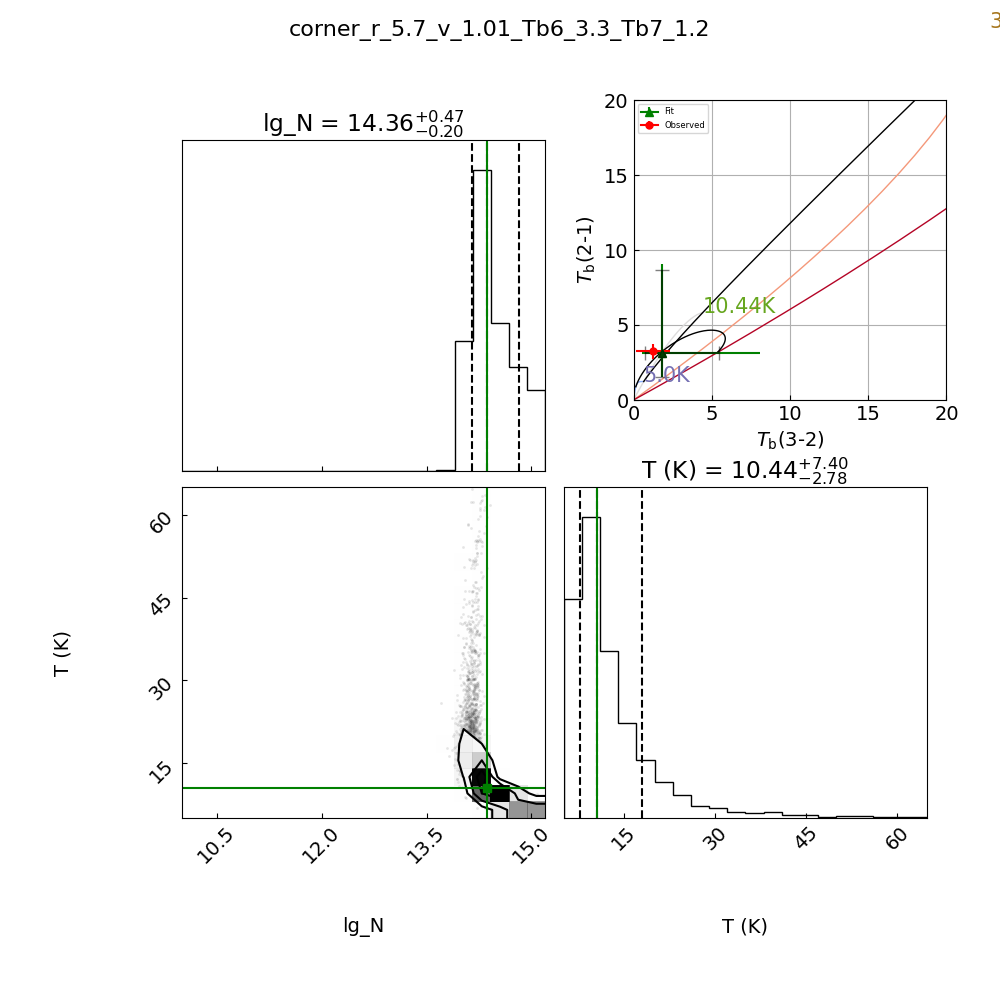

In [23]:
op_dir_label = "rs_empkep_fixr_results_rms_newcurve_lwerN_bnds"

Texe_rs_empkep_fix_r = []
Texe_upq_empkep_fix_r = []
Texe_lq_empkep_fix_r = []

Ncol_rs_empkep_fix_r = []
Ncol_upq_empkep_fix_r = []
Ncol_lq_empkep_fix_r = []

Tb_6_predictions = []
Tb_7_predictions = []


plot_corner = True

np.random.seed(41)

# N_conv_fraction = 1.e-7
lg_n_bounds = [10.,15.2]
T_bounds = [5.,65.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0], T_bounds[-1])


ctr = 0

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_on_point_rs"], Tb_df_b6["Tb_on_point_rs"], 
                          pv_b6.r_as_rs, pv_b6.v_rot_redshifted):

    print(f"estimating for r = {r:.3e} arcsec, v = {v: .2f} Kmps , Tb7 = {Tb7:.1f}, Tb6 = {Tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = Tb7, t2=Tb6, 
                                                    s1=np.sqrt( 1.08**2 ), #(0.1*Tb7)**2 + 1.08**2
                                                    s2=np.sqrt( 0.49**2 ),  # (0.1*Tb6)**2 + 0.49**2
                                                    estimator='mcmc', like_function = 'chisq', initial_params = [lg_n_init, T_init], 
                                                    bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                                    initial_scatter = 0.1, args= None,
                                                    nwalkers = 50, n_steps = 9000, burn_in = 2000, thin_by = 50, 
                                                    return_flat= True, intensity_model = lte_model, plot_chain = True, 
                                                    r_v_info = [str(round(r,3)), str(round(v,2))], 
                                                    chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),
                                                                                    "chains",op_dir_label),
                                                    show_chains = False)
    
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_empkep_fix_r.append(T_qtls[0])
    Texe_rs_empkep_fix_r.append(T_qtls[1])
    Texe_upq_empkep_fix_r.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_empkep_fix_r.append(Ncol_qtls[0])
    Ncol_rs_empkep_fix_r.append(Ncol_qtls[1])
    Ncol_upq_empkep_fix_r.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt, ax_lt, Tb_6_prediction, Tb_7_prediction = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=Tb7, tb6=Tb6, figure = fig1,
                                axes = ax)
        
        Tb_6_predictions.append(Tb_6_prediction)
        Tb_7_predictions.append(Tb_7_prediction)
                            
        fig1.suptitle('corner_r_'+str(round(r,2))+'_v_'+str(round(v,2)) + '_Tb6_' + str(round(Tb6,1))+ '_Tb7_' + str(round(Tb7,1)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(r,2))+'_v_'+str(round(v,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


In [19]:
# Calculate errorbars

T_err_empkep_rs_fix_r = [np.array(Texe_rs_empkep_fix_r)-np.array(Texe_lq_empkep_fix_r),
                         np.array(Texe_upq_empkep_fix_r)-np.array(Texe_rs_empkep_fix_r)] 

N_err_empkep_rs_fix_r = [np.array(Ncol_rs_empkep_fix_r)-np.array(Ncol_lq_empkep_fix_r), 
                         np.array(Ncol_upq_empkep_fix_r)-np.array(Ncol_rs_empkep_fix_r)]

In [20]:
results_data_fix_r = {"r_empkep_rs_fix_r": pv_b6.r_as_rs,
        "Tb7_empkep_rs_fix_r" : Tb_df_b7["Tb_on_point_rs"], "Tb6_empkep_rs_fix_r" : Tb_df_b6["Tb_on_point_rs"],
        "Texe_rs_empkep_fix_r" : Texe_rs_empkep_fix_r, "Texe_err_rs_empkep_fix_r" : np.array(T_err_empkep_rs_fix_r).T.tolist(),
        "Ncol_rs_empkep_fix_r" : Ncol_rs_empkep_fix_r, "Ncol_err_rs_empkep_fix_r" : np.array(N_err_empkep_rs_fix_r).T.tolist()
        }
results_df_fix_r = pd.DataFrame(data = results_data_fix_r)

res_path = os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv")
print(res_path)
if not os.path.exists(res_path):

        df = pd.DataFrame(results_df_fix_r)
        df.to_csv(res_path, index=False)

existing_results = pd.read_csv(res_path)

updated_results = pd.concat([existing_results, results_df_fix_r], axis=1)

updated_results.to_csv(path_or_buf= res_path)

d:\L1489_IRS_ssp\LTEAnalysis\rs_empkep_fixr_results_rms_newcurve_lwerN_bnds.csv


#### Visualize results

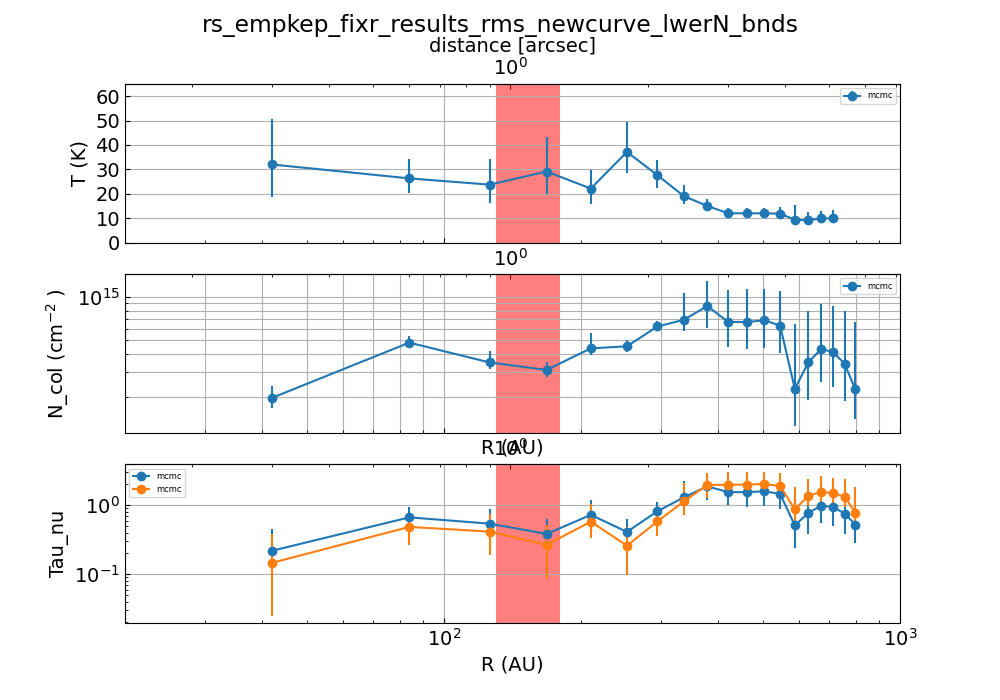

In [27]:
N_conv_fraction = 1.
vis_results_fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)


tau_nu_6, tau_nu_6_err = [], []
tau_nu_7, tau_nu_7_err = [], []


for tupple_6, tupple_7 in zip(Tb_6_predictions, Tb_7_predictions):

    tau_nu_6.append(tupple_6[2])
    tau_nu_6_err.append(np.squeeze(tupple_6[3]))

    tau_nu_7.append(tupple_7[2])
    tau_nu_7_err.append(np.squeeze(tupple_7[3]))

acceptable_r_range = [0.3, 15.0]

ftd_r_as_rs_fix_r, ftd_Texe_rs_empkep_fix_r, ftd_Terr_rs_empkep_fix_r = zip(*filter(lambda triple: acceptable_r_range[0] <= triple[0] 
                                                                                    <= 5.1, 
                                                                                    zip(pv_b6.r_as_rs, Texe_rs_empkep_fix_r, 
                                                                                        np.array(T_err_empkep_rs_fix_r).T.tolist())))

axes[0].errorbar(np.array(ftd_r_as_rs_fix_r)*140., ftd_Texe_rs_empkep_fix_r, 
                 yerr=np.array(ftd_Terr_rs_empkep_fix_r).T, marker='o', label = 'mcmc')
axes[0].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
#axes[0].set_xlim(10, 800)
axes[0].set_ylim(0,65)
axes[0].set_yticks([0,10,20,30,40,50,60])
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[0].legend(prop={'size': 6})

secax_0 = axes[0].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))
secax_0.set_xlabel('distance [arcsec]')

ftd_r_as_rs_fix_r, ftd_Ncol_rs_empkep_fix_r, ftd_N_err_rs_empkep_fix_r = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Ncol_rs_empkep_fix_r, np.array(N_err_empkep_rs_fix_r).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[1].errorbar(np.array(ftd_r_as_rs_fix_r)*140., np.array(Ncol_rs_empkep_fix_r)*N_conv_fraction, 
                 yerr=np.array(ftd_N_err_rs_empkep_fix_r).T*N_conv_fraction, 
                 marker='o', label = 'mcmc')
axes[1].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True, which = 'both')
axes[1].legend(prop={'size': 6})
axes[1].set_xlabel("R (AU)")


secax_1 = axes[1].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))
#secax_1.set_xlabel('distance [arcsec]')


ftd_r_as_bs_fix_r, ftd_Tauvu_6_bs_empkep_fix_r, \
    ftd_Tauvu_6_bs_err_empkep_fix_r = zip(*[(r, tau_6, tau6_err) for r, tau_6, tau6_err in 
                                        zip(pv_b6.r_as_rs, tau_nu_6, 
                                            np.array(tau_nu_6_err).tolist()) 
                                        if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

ftd_r_as_bs_fix_r, ftd_Tauvu_7_bs_empkep_fix_r, \
    ftd_Tauvu_7_bs_err_empkep_fix_r = zip(*[(r, tau_7, tau7_err) for r, tau_7, tau7_err in 
                                        zip(pv_b7.r_as_rs, tau_nu_7, 
                                            np.array(tau_nu_7_err).tolist()) 
                                        if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[2].errorbar(np.array(ftd_r_as_rs_fix_r)*140., np.array(ftd_Tauvu_7_bs_empkep_fix_r), 
                 yerr=np.array(ftd_Tauvu_7_bs_err_empkep_fix_r).T, 
                 marker='o', label = 'mcmc')
axes[2].errorbar(np.array(ftd_r_as_rs_fix_r)*140., np.array(ftd_Tauvu_6_bs_empkep_fix_r), 
                 yerr=np.array(ftd_Tauvu_7_bs_err_empkep_fix_r).T, 
                 marker='o', label = 'mcmc')
axes[2].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[2].set_ylabel(r"Tau_nu")
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].grid(True)
axes[2].legend(prop={'size': 6})
axes[2].set_xlabel("R (AU)")

axes[2].set_xlim(20,1000)

secax_2 = axes[2].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))
#secax_2.set_xlabel('distance [arcsec]')



vis_results_fig.suptitle(op_dir_label)

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)


if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')